In [93]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [94]:
data = pd.read_hdf('data/data_alpha_factor.h5', 'data/top500')
price_sample = pd.read_hdf('data/data_alpha_factor.h5', 'data/sample')

In [95]:
data.sample(10)

open       high        low      close      volume  \
ticker date                                                                 
AKS    2008-12-01   6.663464   6.823387   6.041540   6.041540   5198300.0   
MO     2007-02-12  11.238746  11.327064  11.225565  11.283564   7683100.0   
ROST   2007-02-13   7.351755   7.467917   7.309311   7.461215   5477200.0   
PAY    2007-06-20  36.720000  37.490000  36.620000  36.990000   1573000.0   
MAR    2013-07-23  39.078908  39.163556  38.458160  38.514592   1402500.0   
WMB    2007-01-05  13.993510  14.196156  13.933264  14.108525   5845500.0   
       2007-02-13  15.127231  15.236769  15.066985  15.182000   3790700.0   
AAP    2007-12-31  36.914349  36.982046  36.604875  36.740270   1051400.0   
AN     2015-10-22  63.090000  63.090000  61.490000  61.640000   1293187.0   
MRVL   2007-07-24  17.153853  17.270607  16.686837  16.902383  15786200.0   

                      marketcap  sector    ret_01    ret_02    ret_03  \
ticker date                                                             
AKS    2008-12-01  1.380000e+09     5.0 -0.137056 -0.209302 -0.008746   
MO     2007-02-12  1.068600e+11    11.0  0.002459  0.004459 -0.004420   
ROST   2007-02-13  3.207000e+10     1.0  0.018293  0.019536  0.015506   
PAY    2007-06-20  2.530000e+09     9.0  0.009552  0.008451  0.015930   
MAR    2013-07-23  4.400000e+10     1.0 -0.012539 -0.016098 -0.025232   
WMB    2007-01-05  2.238000e+10     3.0  0.005464       NaN       NaN   
       2007-02-13  2.238000e+10     3.0  0.005806 -0.003236 -0.004668   
AAP    2007-12-31  9.990000e+09     1.0 -0.004716 -0.006797 -0.016058   
AN     2015-10-22  4.390000e+09     7.0 -0.000486 -0.009481 -0.009003   
MRVL   2007-07-24  1.054000e+10     2.0 -0.022845 -0.041752 -0.035366   

                     ret_04    ret_05    ret_10    ret_21    ret_42    ret_63  \
ticker date                                                                     
AKS    2008-12-01 -0.031339  0.095008 -0.220183 -0.491287 -0.716661 -0.856261   
MO     2007-02-12 -0.004883 -0.014733 -0.027935 -0.042506       NaN       NaN   
ROST   2007-02-13  0.030864  0.037267  0.034056  0.003304       NaN       NaN   
PAY    2007-06-20  0.024086  0.032375  0.104509 -0.014913  0.036425 -0.015176   
MAR    2013-07-23 -0.009434 -0.013015 -0.018927  0.051888 -0.042553 -0.018085   
WMB    2007-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
       2007-02-13  0.013528  0.017248  0.028190  0.073171       NaN       NaN   
AAP    2007-12-31 -0.013247 -0.012734 -0.000789  0.066422  0.110623  0.140928   
AN     2015-10-22  0.006861  0.004400  0.016826  0.033708  0.066436  0.018506   
MRVL   2007-07-24 -0.011555 -0.029897  0.018950  0.045556  0.174782  0.110980   

                    ret_126   ret_252   ret_fwd  
ticker date                                      
AKS    2008-12-01 -0.900920 -0.844610  0.052941  
MO     2007-02-12       NaN       NaN  0.005257  
ROST   2007-02-13       NaN       NaN  0.036826  
PAY    2007-06-20       NaN       NaN -0.013247  
MAR    2013-07-23  0.051192  0.114164 -0.014164  
WMB    2007-01-05       NaN       NaN  0.006599  
       2007-02-13       NaN       NaN -0.005051  
AAP    2007-12-31 -0.071016       NaN -0.010529  
AN     2015-10-22 -0.048765  0.220836 -0.000973  
MRVL   2007-07-24  0.025613       NaN -0.001594

In [96]:
price_sample.sample(5)

open        high         low       close       volume  \
date                                                                      
2015-03-02  123.269201  124.251540  122.363160  123.116605   48096663.0   
2011-07-25   50.165416   51.405575   50.071600   51.212804  147451500.0   
2015-03-26  117.079513  119.101414  116.926917  118.491029   47572869.0   
2013-05-31   59.404304   60.008193   59.010463   59.041314   96075700.0   
2009-02-03   11.813001   12.000631   11.602238   11.949226  149827300.0   

               marketcap  sector  
date                              
2015-03-02  9.039900e+11     2.0  
2011-07-25  9.039900e+11     2.0  
2015-03-26  9.039900e+11     2.0  
2013-05-31  9.039900e+11     2.0  
2009-02-03  9.039900e+11     2.0

In [97]:
# TAlib Library Function Groups
function_groups = ['Overlap Studies', 'Momentum Indicators', 'Volume Indicators', 'Volatility Indicators',
                   'Price Transform', 'Cycle Indicators', 'Pattern Recognition', 'Statistic Functions',
                   'Math Transform', 'Math Operators']
talib_grps = talib.get_function_groups()
talib_grps

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

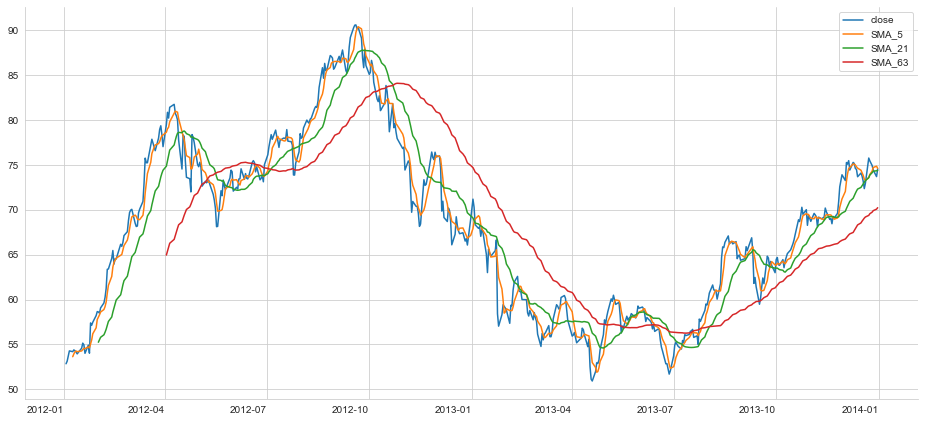

In [98]:
# 1. Moving Averages : SMA(Simple Moving Average), EMA, WMA, DEMA(Double Exponential Moving Average), TEMA(Triple Exponential Moving Average), TRIMA(Triangular Moving Average), KAMA(Kaufman Adaptive Moving Average), MAMA(MESA Adaptive Moving Average), TEMA(Triple Exponential Moving Average)

# 1-1. Simple Moving Average (SMA)
df = price_sample.loc['2012': '2013', ['close']] # sample ticker : AAPL
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = talib.SMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

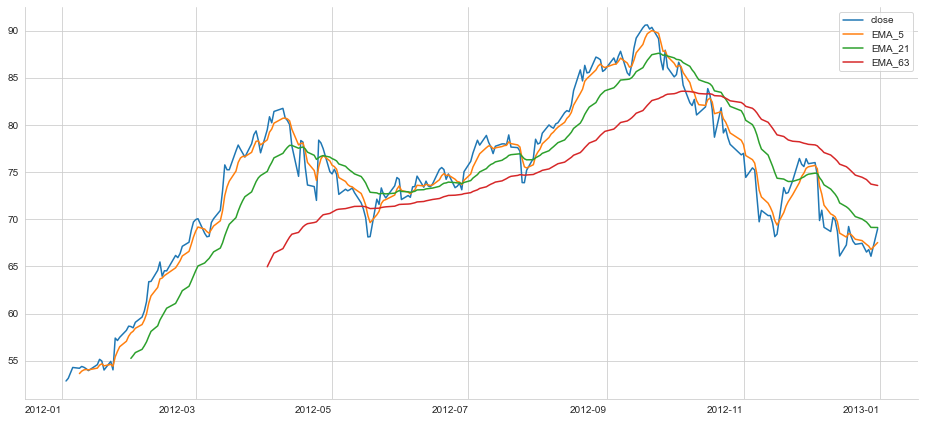

In [99]:
# 1-2. Exponential Moving Average (EMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'EMA_{t}'] = talib.EMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

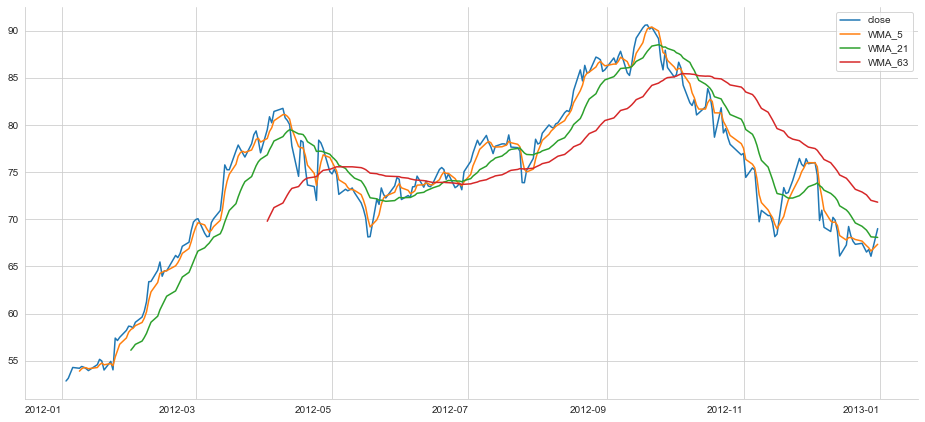

In [100]:
# 1-3. Weighted Moving Average (WMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'WMA_{t}'] = talib.WMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

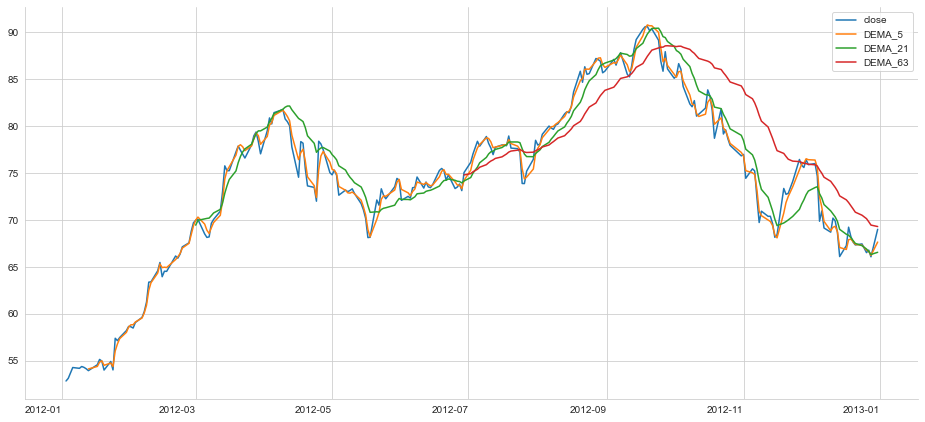

In [101]:
# 1-4. Double Exponential Moving Average (DEMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'DEMA_{t}'] = talib.DEMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

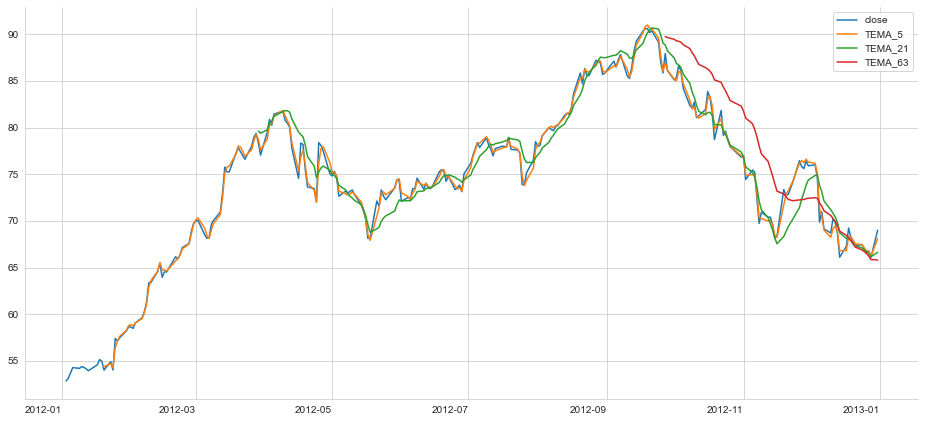

In [102]:
# 1-5. Triple Exponential Moving Average (TEMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'TEMA_{t}'] = talib.TEMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

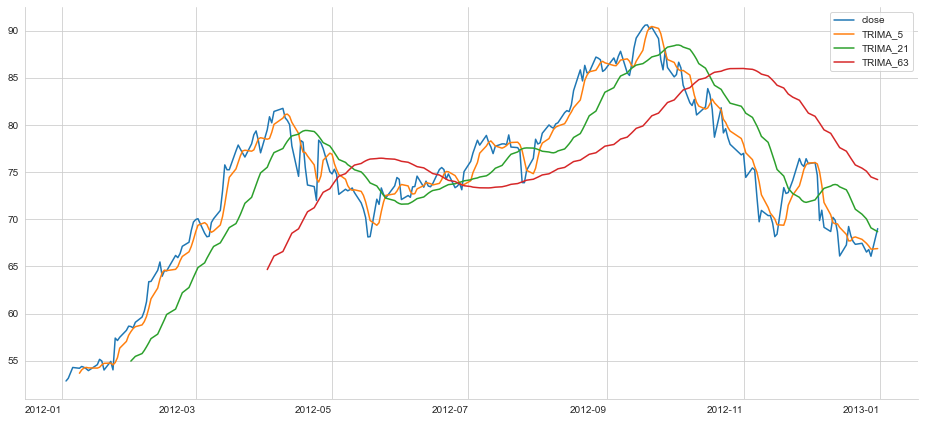

In [103]:
# Triangular Moving Average (TRIMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'TRIMA_{t}'] = talib.TRIMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

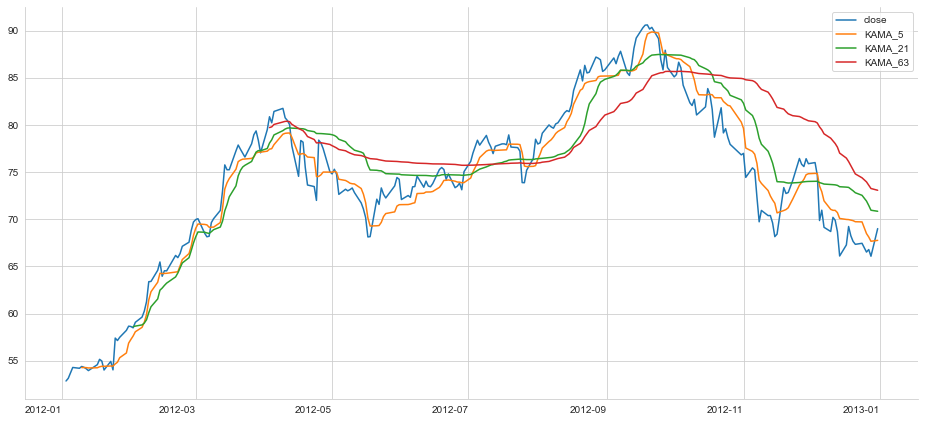

In [104]:
# 1-6. Kaufman Adaptive Moving Average (KAMA)
df = price_sample.loc['2012', ['close']]
for t in [5, 21, 63]:
    df[f'KAMA_{t}'] = talib.KAMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

len(talib.MAMA) : 2


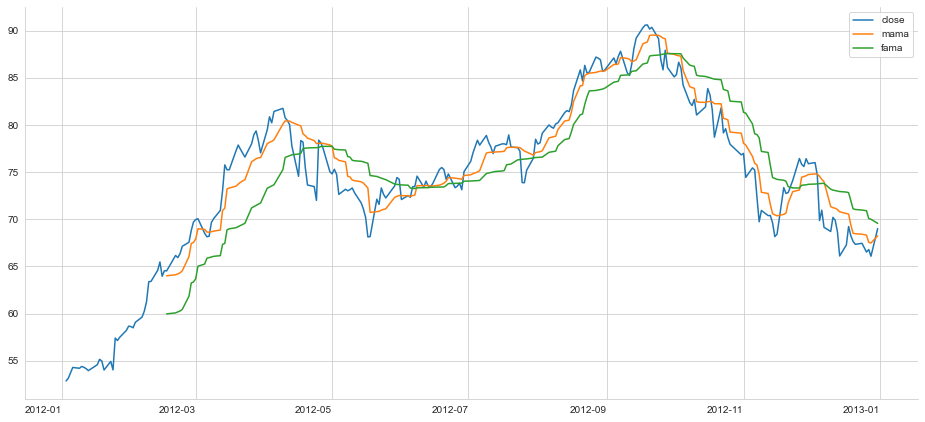

In [105]:
# 1-7. MESA Adaptive Moving Average (MAMA)
df = price_sample.loc['2012', ['close']]
print(f'len(talib.MAMA) : {len(talib.MAMA(df.close, fastlimit=.5, slowlimit=.05))}')

mama, fama = talib.MAMA(df.close, fastlimit=.5, slowlimit=.05)
df['mama'] = mama
df['fama'] = fama
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

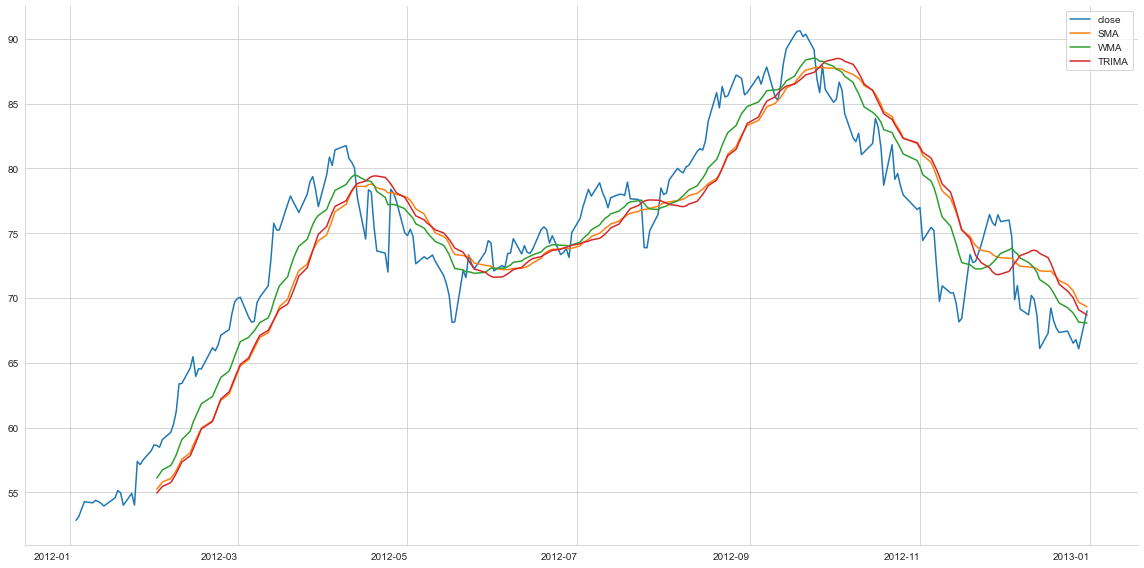

In [106]:
# Comparison Above MAs
df = price_sample.loc['2012', ['close']]
t = 21
df['SMA'] = talib.SMA(df.close, timeperiod=t)
df['WMA'] = talib.WMA(df.close, timeperiod=t)
df['TRIMA'] = talib.TRIMA(df.close, timeperiod=t)

ax = df[['close', 'SMA', 'WMA', 'TRIMA']].plot(figsize=(16, 8), rot=0)

sns.despine()
ax.set_xlabel('')
plt.tight_layout();

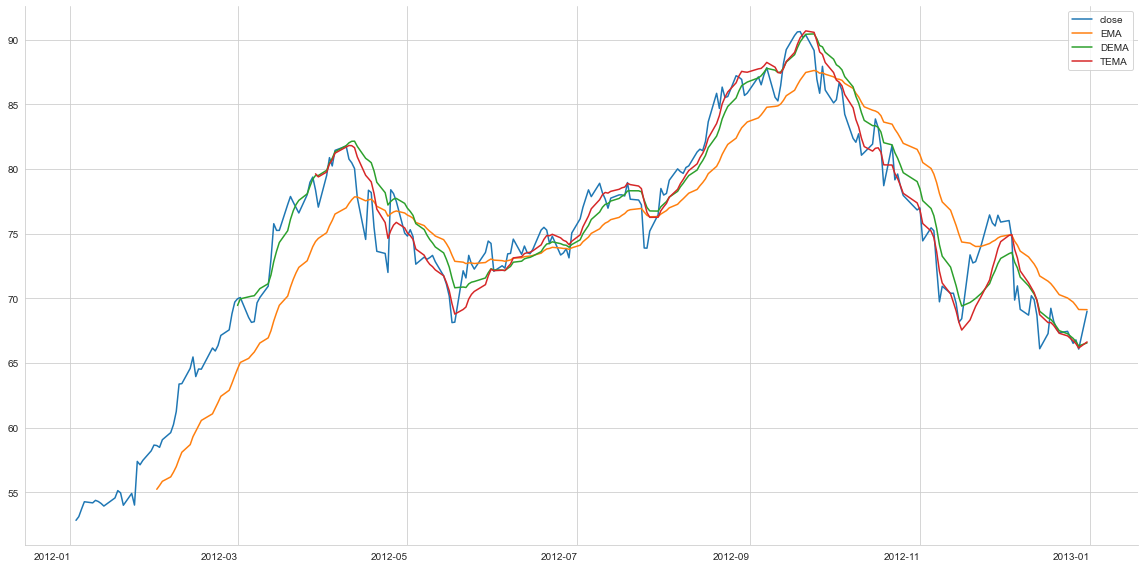

In [107]:
df['EMA'] = talib.EMA(df.close, timeperiod=t)
df['DEMA'] = talib.DEMA(df.close, timeperiod=t)
df['TEMA'] = talib.TEMA(df.close, timeperiod=t)

ax = df[['close', 'EMA', 'DEMA', 'TEMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

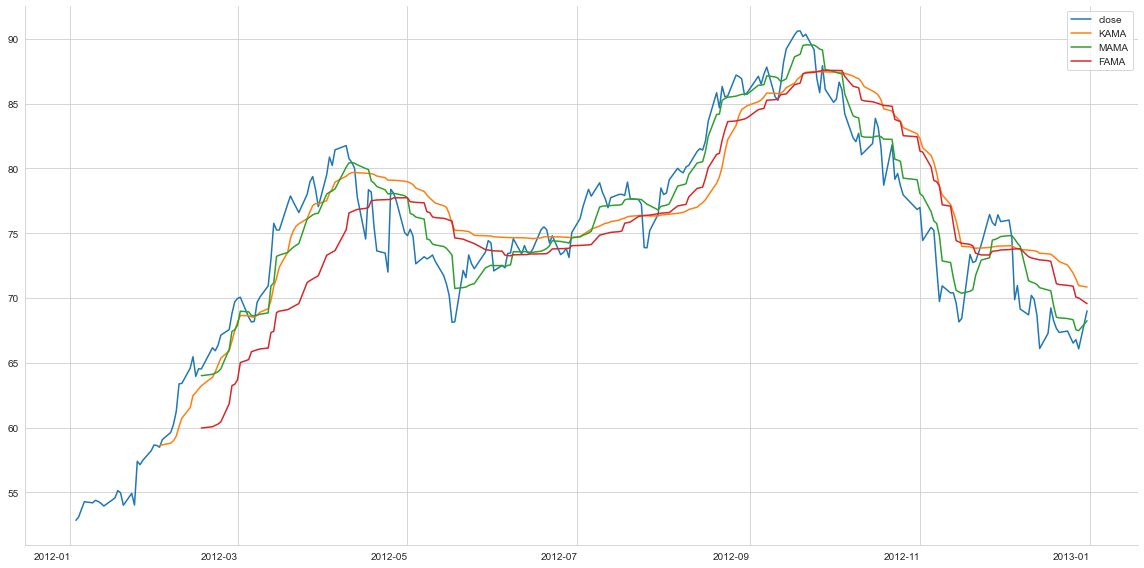

In [108]:
df['KAMA'] = talib.KAMA(df.close, timeperiod=t)
mama, fama = talib.MAMA(df.close, fastlimit=.5, slowlimit=.05)
df['MAMA'] = mama
df['FAMA'] = fama
ax = df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

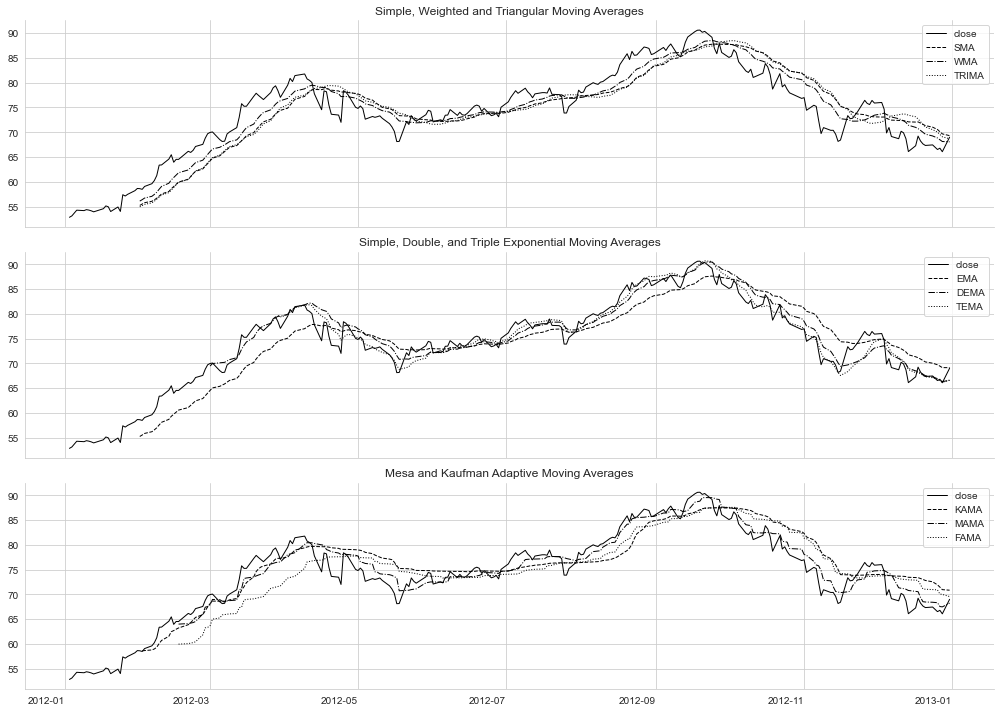

In [109]:
fig, axes = plt.subplots(nrows=3, figsize=(14, 10), sharex=True, sharey=True)


df[['close', 'SMA', 'WMA', 'TRIMA']].plot(rot=0, ax=axes[0],
                                          title='Simple, Weighted and Triangular Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
df[['close', 'EMA', 'DEMA', 'TEMA']].plot(rot=0, ax=axes[1],
                                          title='Simple, Double, and Triple Exponential Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')

df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(rot=0, ax=axes[2],
                                          title='Mesa and Kaufman Adaptive Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
axes[2].set_xlabel('')
sns.despine()
plt.tight_layout();

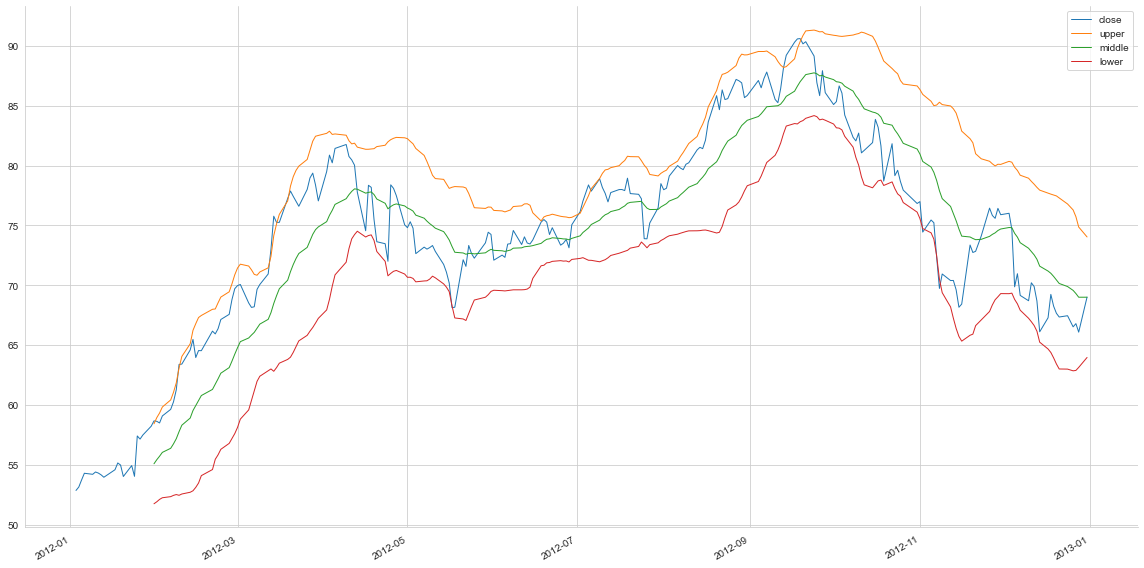

In [110]:
# 2. Overlap Studies : BBANDS, HT_TRENDLINE, MAVP, MA, MIDPOINT, MIDPRICE, SAR, SAREXT

# 2-1. Bollinger Bands
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )
bb_bands = ['upper', 'middle', 'lower']
df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 8), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

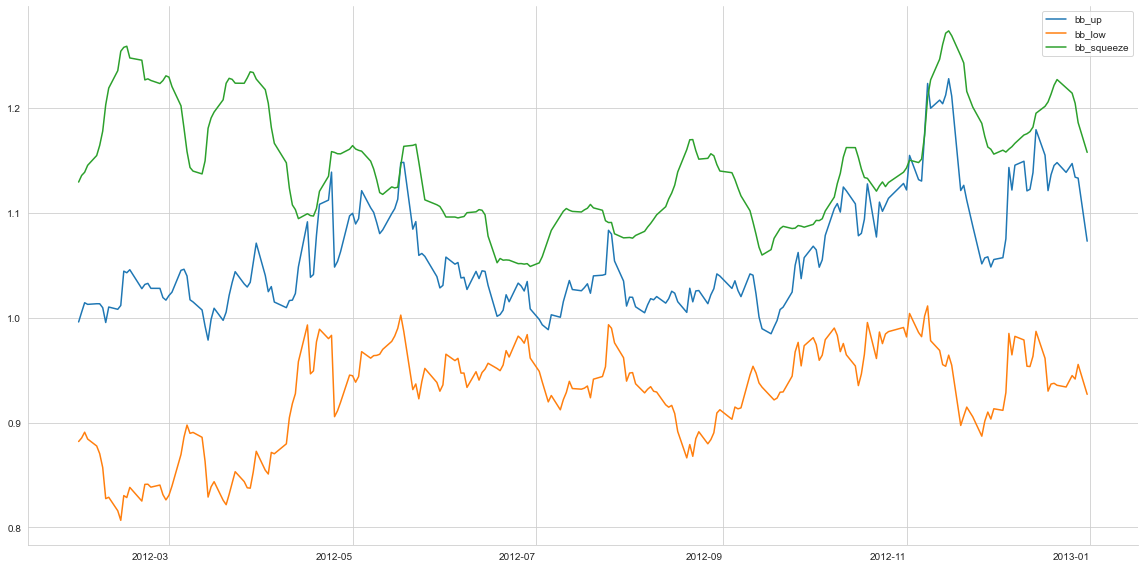

In [111]:
# Normalized squeeze & mean reversion indicators
fig, ax = plt.subplots(figsize=(16,8))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [112]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, timeperiod=20, matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 'BB_LOW': bb_low, 'BB_SQUEEZE': squeeze}, index=close.index)
data = (data.join(data.groupby(level='ticker').close.apply(compute_bb_indicators)))

In [113]:
data.sample(10)

open        high         low       close      volume  \
ticker date                                                                     
CRM    2011-03-25   32.337500   32.560000   31.807500   31.862500  11244000.0   
PFG    2010-11-30   22.382890   22.688093   22.304527   22.469502   2131400.0   
UTX    2015-01-29  109.295016  109.435282  107.041415  108.892922   6328453.0   
CCK    2011-03-15   37.420000   37.900000   36.850000   37.150000   2619200.0   
NBL    2014-04-11   65.805623   66.870224   65.805623   66.014741   1369500.0   
ED     2013-08-06   50.748166   50.765059   50.376508   50.511657   1194800.0   
PPL    2014-03-20   25.594603   25.618456   25.284510   25.610505   4820700.0   
PFE    2014-07-31   26.016265   26.069613   25.518346   25.518346  38348200.0   
EQT    2008-03-20   52.620502   52.620502   50.375554   51.724333   1733600.0   
EQR    2011-08-08   38.304093   38.656282   36.578366   36.592453   4841600.0   

                      marketcap  sector    ret_01    ret_02    ret_03  ...  \
ticker date                                                            ...   
CRM    2011-03-25  1.024000e+11     2.0 -0.013926  0.043646  0.049058  ...   
PFG    2010-11-30  1.524000e+10     0.0 -0.012328 -0.010534 -0.027490  ...   
UTX    2015-01-29  9.994000e+10     4.0 -0.004020 -0.022743 -0.019368  ...   
CCK    2011-03-15  6.000000e+09     7.0 -0.031796 -0.047192 -0.047436  ...   
NBL    2014-04-11  1.680000e+10     8.0 -0.001151 -0.018791 -0.015592  ...   
ED     2013-08-06  2.438000e+10     3.0 -0.003831 -0.009442 -0.008785  ...   
PPL    2014-03-20  2.214000e+10     3.0  0.000000 -0.017988 -0.016789  ...   
PFE    2014-07-31  2.126300e+11     6.0 -0.019139 -0.026067 -0.038039  ...   
EQT    2008-03-20  1.447000e+10     8.0 -0.017031 -0.064506 -0.047190  ...   
EQR    2011-08-08  2.342000e+10     1.0 -0.066655 -0.091783 -0.130253  ...   

                     ret_10    ret_21    ret_42    ret_63   ret_126   ret_252  \
ticker date                                                                     
CRM    2011-03-25 -0.003285 -0.051147  0.028071 -0.058993  0.067957  0.700467   
PFG    2010-11-30 -0.027260  0.035076  0.071815  0.205269  0.008401  0.094189   
UTX    2015-01-29  0.025810 -0.003508  0.057099  0.101772  0.106785  0.050154   
CCK    2011-03-15 -0.025446 -0.018753  0.114611  0.111943  0.253374  0.353370   
NBL    2014-04-11 -0.023756  0.037496  0.047038  0.075151  0.049441  0.234168   
ED     2013-08-06 -0.009934  0.035857  0.043084 -0.042047  0.076225 -0.030072   
PPL    2014-03-20  0.026777  0.031081  0.101469  0.112751  0.066322  0.117404   
PFE    2014-07-31 -0.057760 -0.037399 -0.025412 -0.062137 -0.044054  0.015757   
EQT    2008-03-20 -0.078387 -0.069684  0.124182  0.105547  0.123847  0.235567   
EQR    2011-08-08 -0.176181 -0.173166 -0.143199 -0.115495 -0.021179  0.136959   

                    ret_fwd     BB_UP    BB_LOW  BB_SQUEEZE  
ticker date                                                  
CRM    2011-03-25  0.004237  0.040820 -0.057132    0.097952  
PFG    2010-11-30  0.033774  0.078039 -0.016609    0.094648  
UTX    2015-01-29 -0.014341  0.038228 -0.049108    0.087336  
CCK    2011-03-15 -0.010498  0.068002 -0.000465    0.068467  
NBL    2014-04-11  0.016271  0.043262 -0.056912    0.100173  
ED     2013-08-06  0.012375  0.020869 -0.019932    0.040801  
PPL    2014-03-20  0.007141  0.019261 -0.036158    0.055419  
PFE    2014-07-31  0.005575  0.074062  0.013399    0.060663  
EQT    2008-03-20  0.025376  0.136480  0.023986    0.112494  
EQR    2011-08-08  0.102406  0.281286  0.063681    0.217605  

[10 rows x 22 columns]

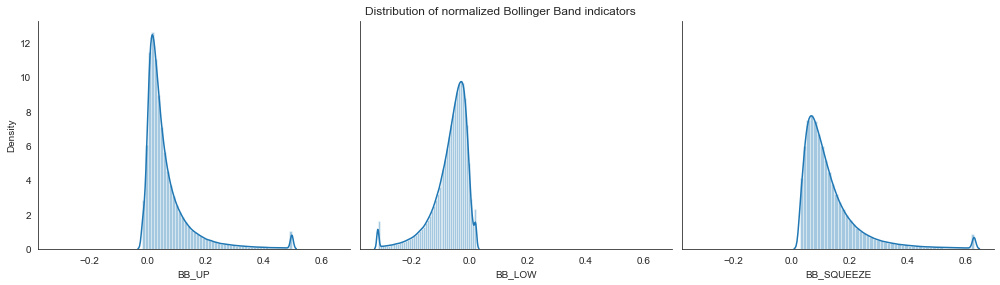

In [114]:
# Visualize Distribution
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

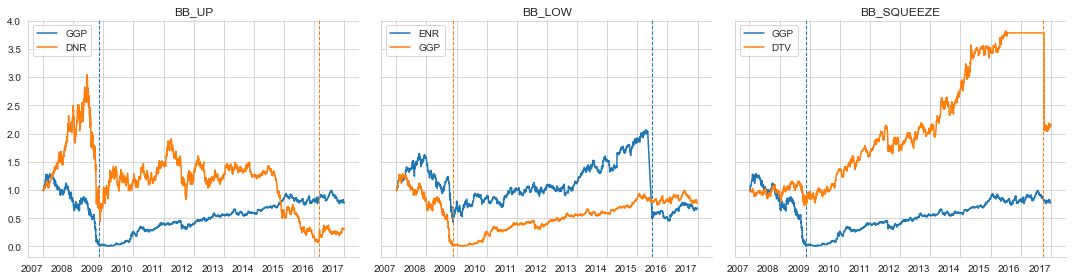

In [115]:
# Plot outlier price series
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    ticker, date = data[indicator].nlargest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    ticker, date = data[indicator].nsmallest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout();

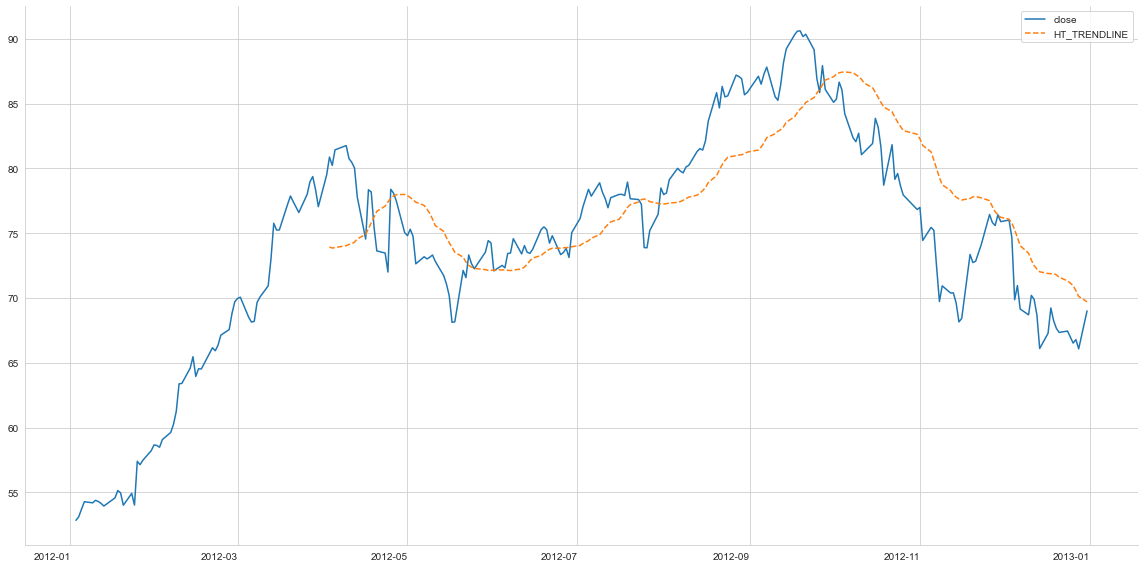

In [116]:
# 2-2. Hilbert Transform - Instantaneous Trendline
df = price_sample.loc['2012', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)
ax = df.plot(figsize=(16, 8), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

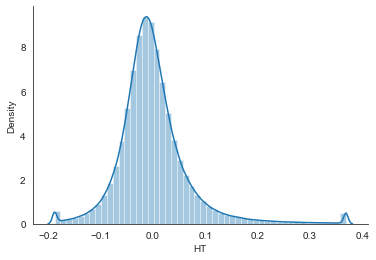

In [117]:
# Compute Hilbert-based normalized indicator
data['HT'] = (data.groupby(level='ticker', group_keys=False).close.apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

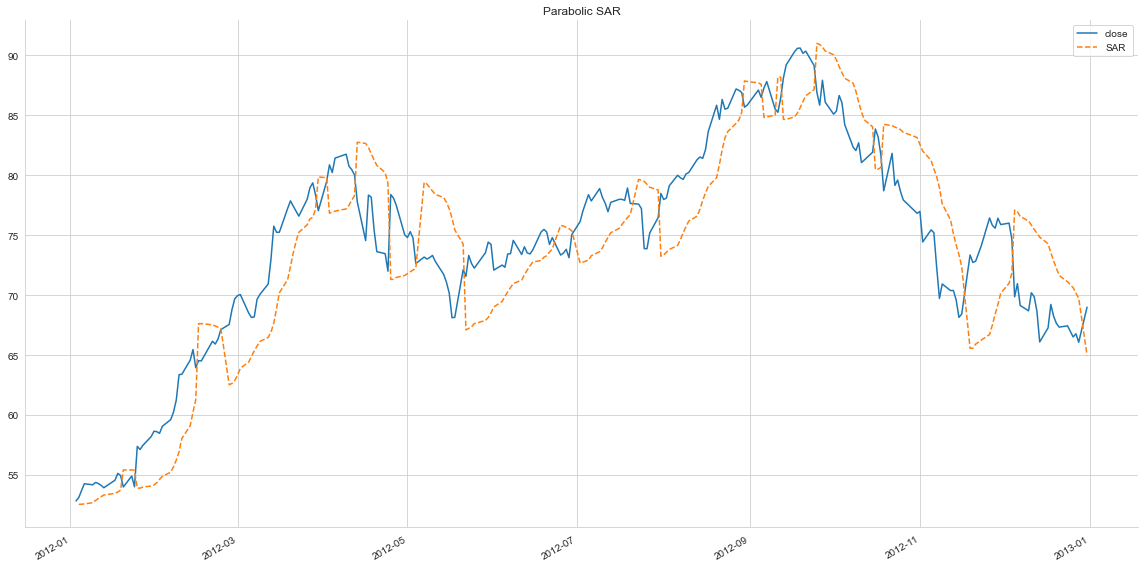

In [118]:
# 2-3. Parabolic SAR
df = price_sample.loc['2012', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, acceleration=0.02, maximum=0.2)
ax = df[['close', 'SAR']].plot(figsize=(16, 8), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

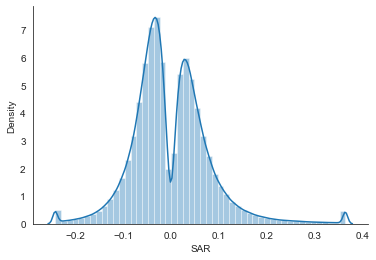

In [119]:
# Normalized SAR indicator
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, x.low, acceleration=acceleration, maximum=maximum)
    return sar/x.close - 1

data['SAR'] = (data.groupby(level='ticker', group_keys=False).apply(compute_sar_indicator))
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

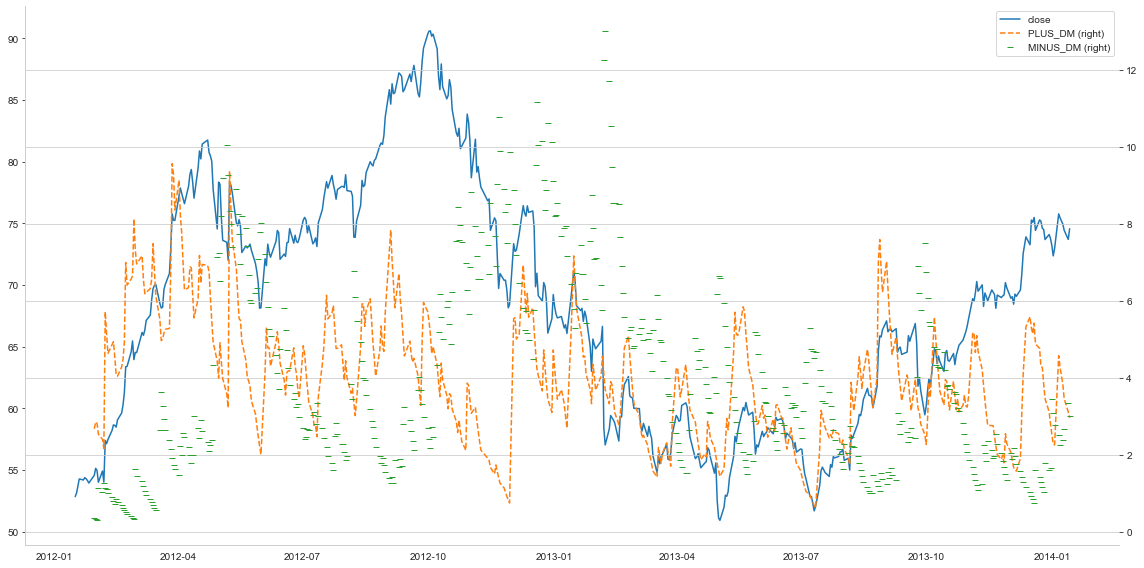

In [120]:
# 3. Momentum Indicators: PLUS_DM(Directional Movement), MINUS_DM, PLUS_DI(Directional Indicator), MINUS_DI, DX(Directional Movement Index), ADX(Average Directional Movement Index), ADXR(Average Directional Movement Index Rating), APO(Absolute Price Oscillator), PPO(Percentage Price Oscillator), AROON, AROONOSC(Aroon Oscillator), BOP(Balance Of Power), CCI(Commodity Channel Index), CMO(Chande Momentum Oscillator), MACD, MACDEXT(MACD with controllable MA type), MACDFIX(MACD Fix 12/26), MFI(Money Flow Index), MOM(Momentum). RSI, STOCH, STOCHF(Stochastic Fast), STOCHRSI(Stochastic Relative Strength Index), TRIX(1-day Rate-Of-Change (ROC) of a Triple Smooth EMA), ULTOSC(Ultimate Oscillator), WILLR(Williams' %R)

# 3-1. Average Directional Movement Index (ADX)
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(16, 8), secondary_y=['PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

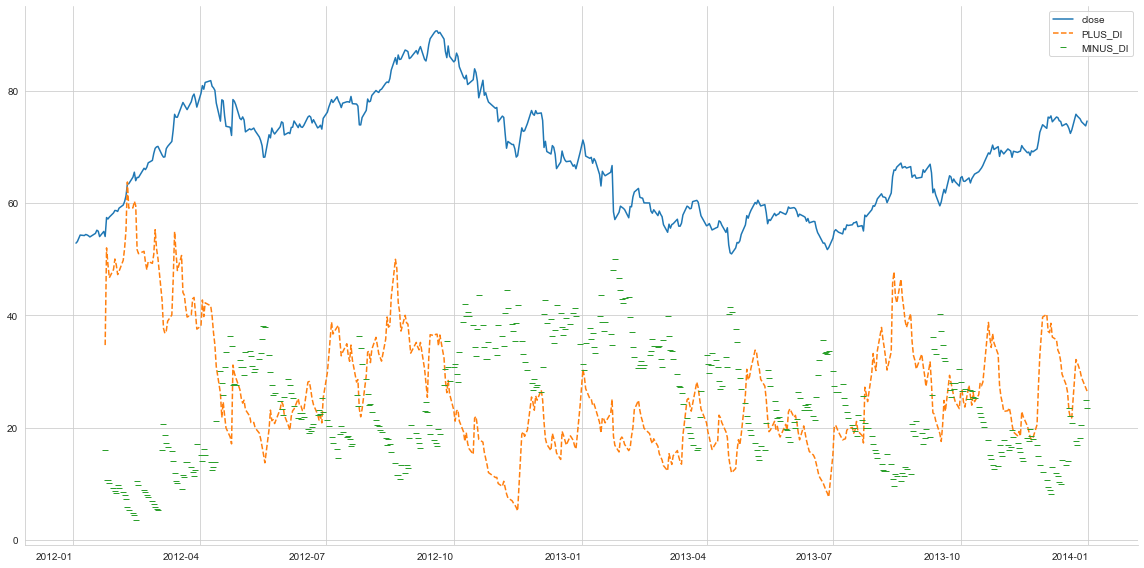

In [121]:
# 3-2. Plus/Minus Directional Index (PLUS_DI/MINUS_DI)
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(16, 8), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

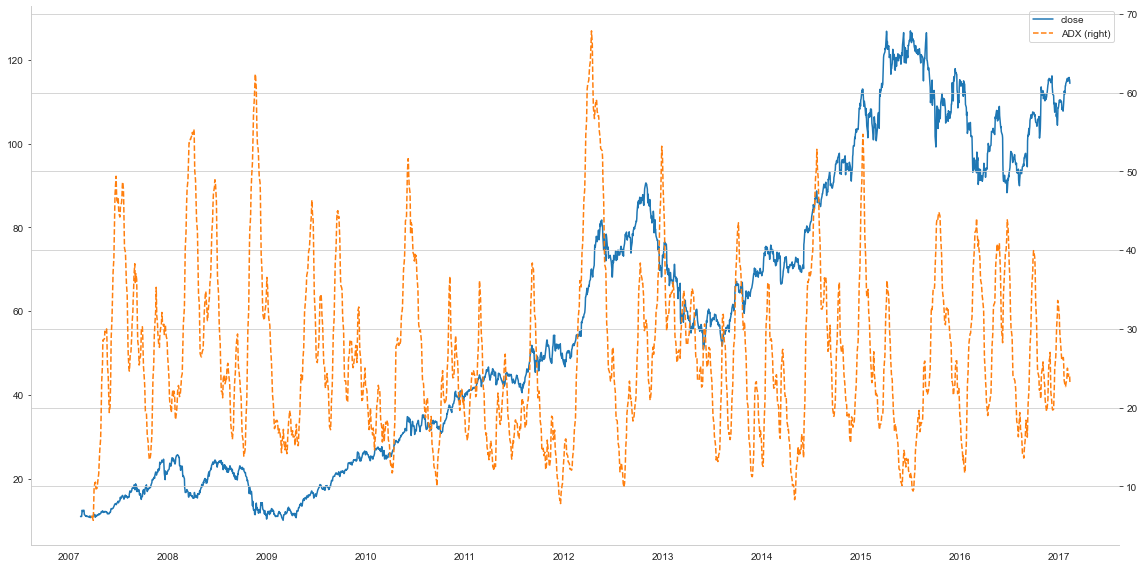

In [122]:
# 3-3. Average directional movement index (ADX)
df = price_sample.loc[:, ['high', 'low', 'close']]
df['ADX'] = talib.ADX(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ADX']].plot(figsize=(16, 8), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

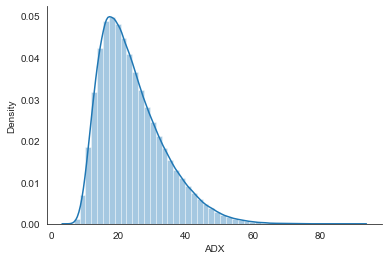

In [123]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, x.low, x.close, timeperiod=timeperiod)
data['ADX'] = (data.groupby(level='ticker', group_keys=False).apply(compute_adx))

with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

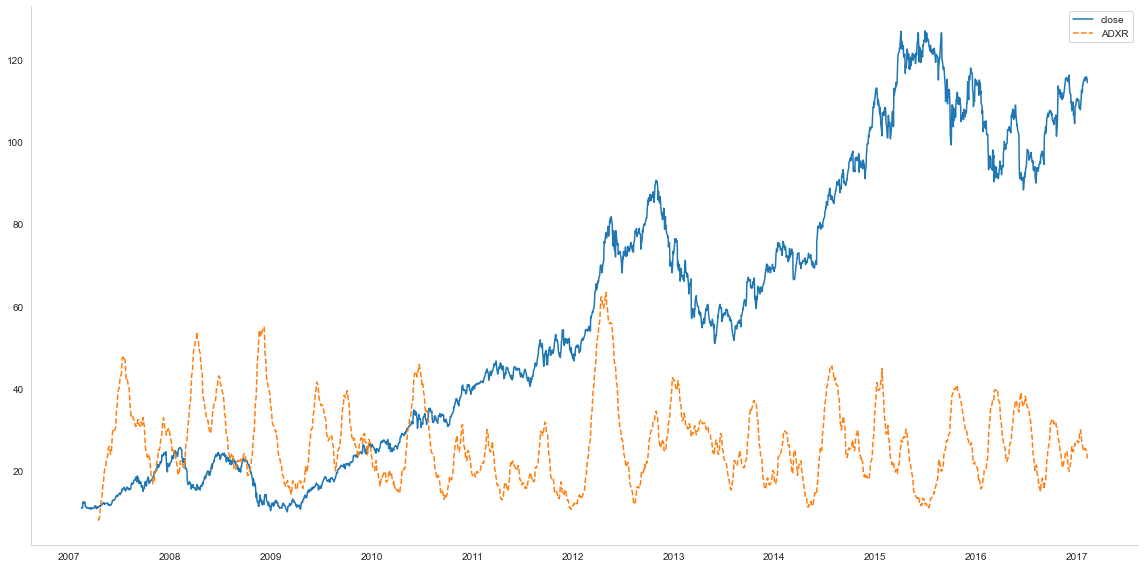

In [124]:
# 3-4. Average Directional Movement Index Rating
df = price_sample.loc[:, ['high', 'low', 'close']]
df['ADXR'] = talib.ADXR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ADXR']].plot(figsize=(16, 8), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

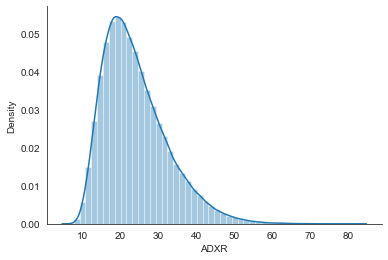

In [125]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, x.low, x.close, timeperiod=timeperiod)
data['ADXR'] = (data.groupby(level='ticker', group_keys=False).apply(compute_adxr))
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

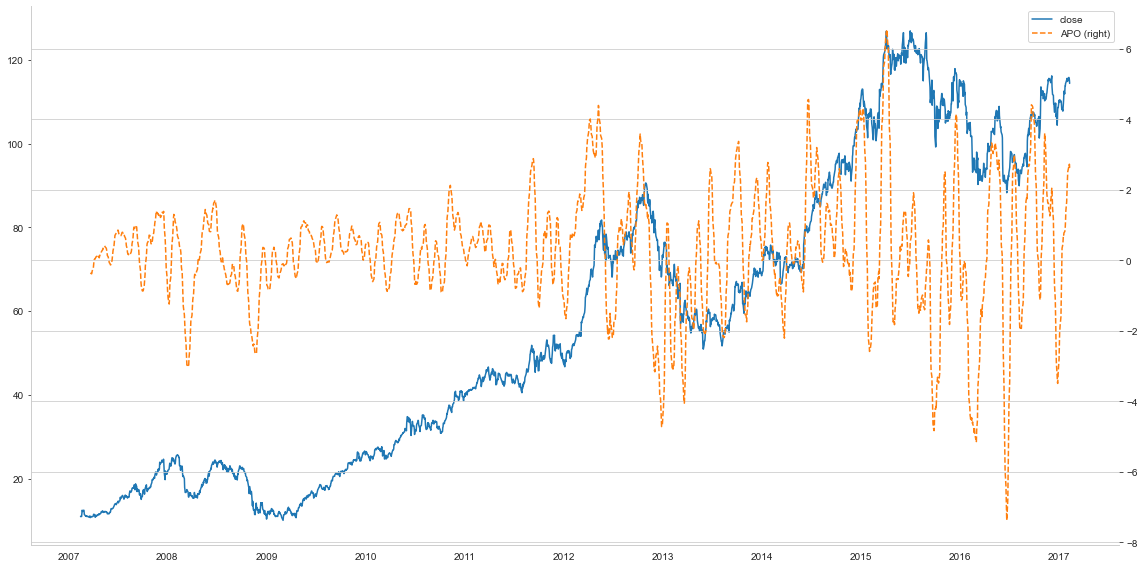

In [126]:
# 3-5. Absolute Price Oscillator (APO)
df = price_sample.loc[:, ['close']]
df['APO'] = talib.APO(df.close, fastperiod=12, slowperiod=26, matype=0)
ax = df.plot(figsize=(16,8), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

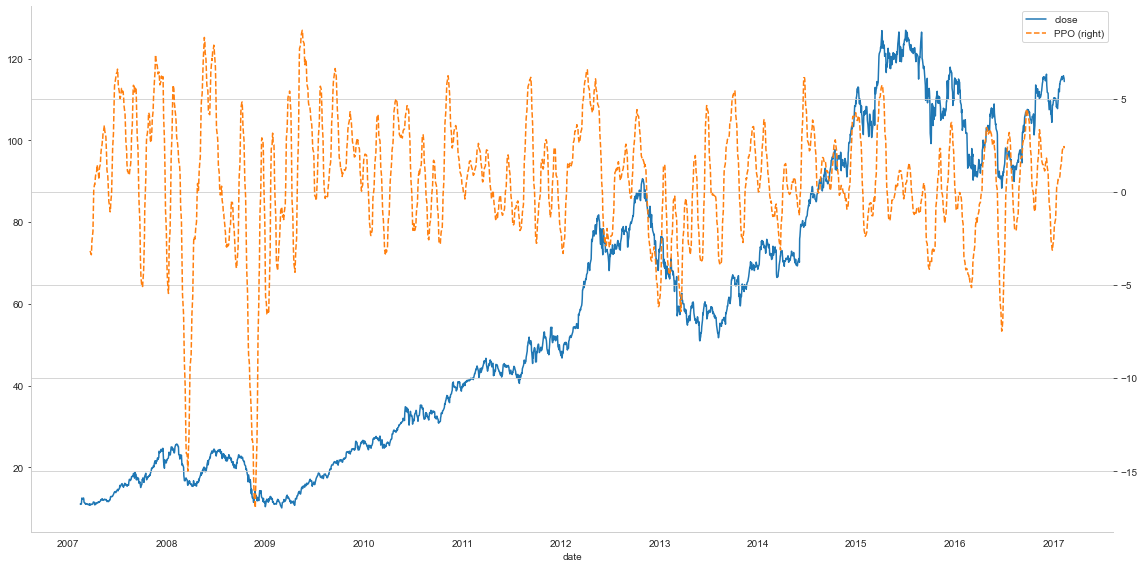

In [127]:
# 3-6. Percentage Price Oscillator (PPO)
df = price_sample.loc[:, ['close']]
df['PPO'] = talib.PPO(df.close, fastperiod=12, slowperiod=26, matype=0)
ax = df.plot(figsize=(16,8), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

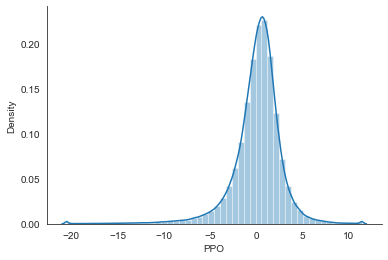

In [128]:
data['PPO'] = (data.groupby(level='ticker').close.apply(talib.PPO, fastperiod=12, slowperiod=26, matype=1))
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q), upper=data.PPO.quantile(1-q)))
    sns.despine()

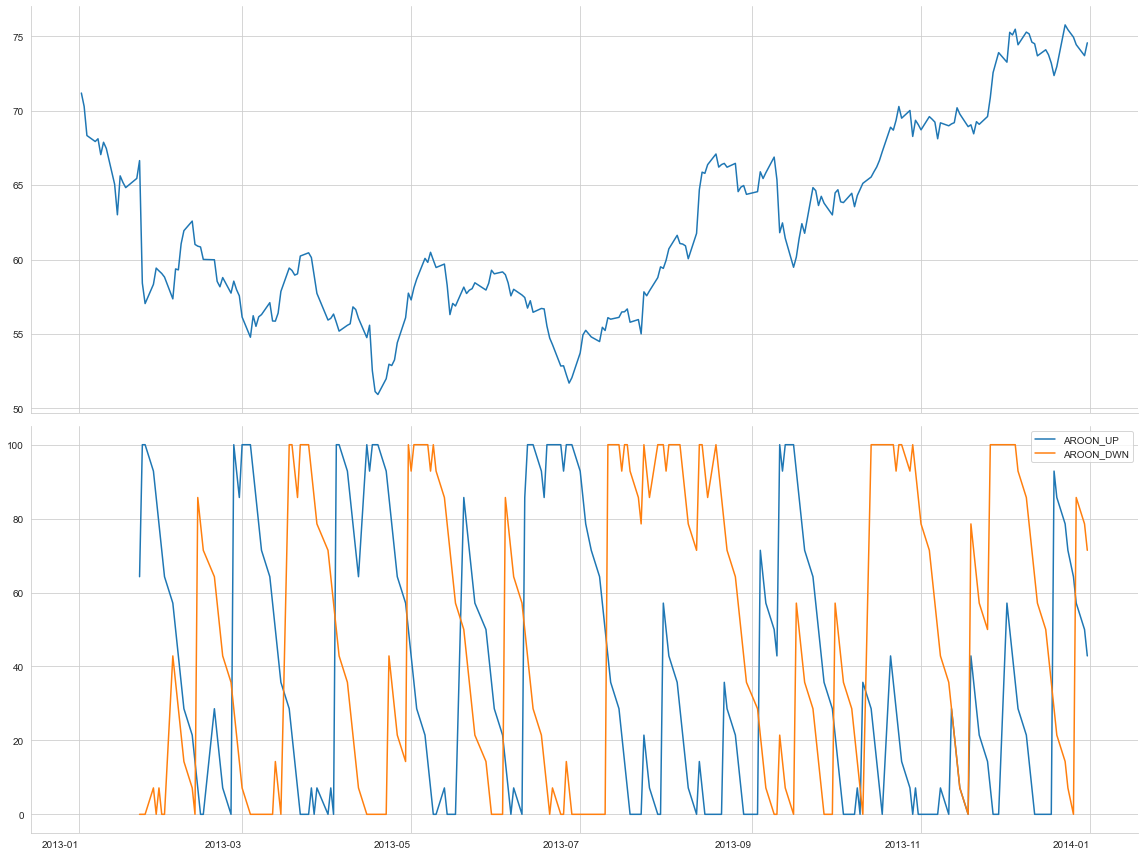

In [129]:
# 3-7. Aroon Oscillator

# Aroon Up/Down Indicator
df = price_sample.loc['2013', ['high', 'low', 'close']]
aroonup, aroondwn = talib.AROON(high=df.high, low=df.low, timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn
fig, axes = plt.subplots(nrows=2, figsize=(16, 12), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

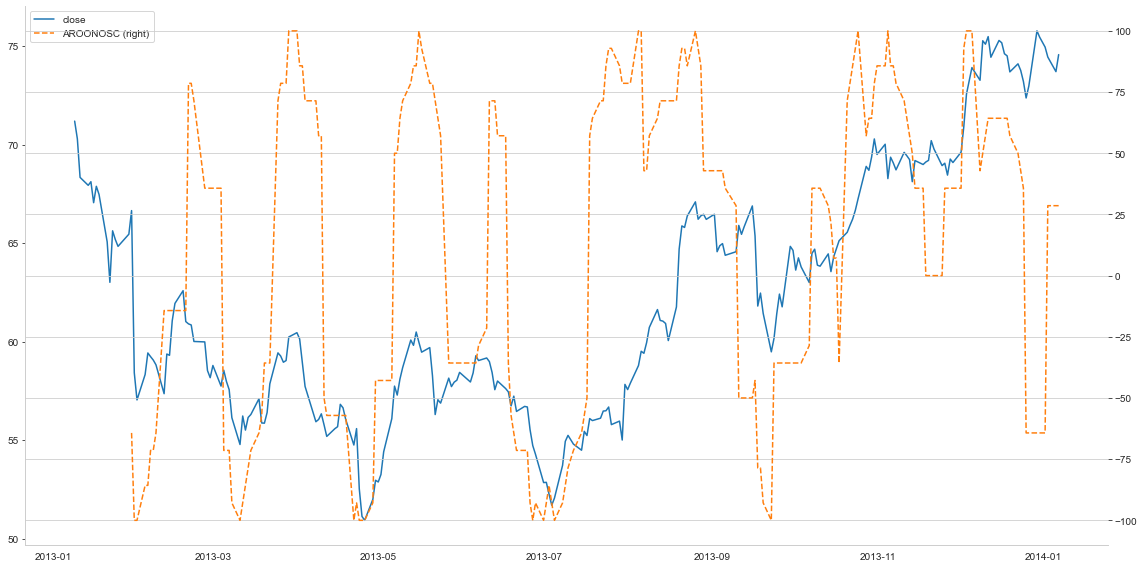

In [130]:
# Aroon Oscillator
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['AROONOSC'] = talib.AROONOSC(high=df.high, low=df.low, timeperiod=14)
ax = df[['close', 'AROONOSC']].plot(figsize=(16,8), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

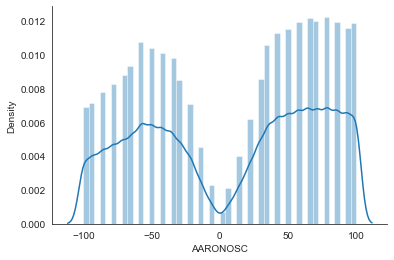

In [131]:
data['AARONOSC'] = (data.groupby('ticker', group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high, low=x.low, timeperiod=14)))
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

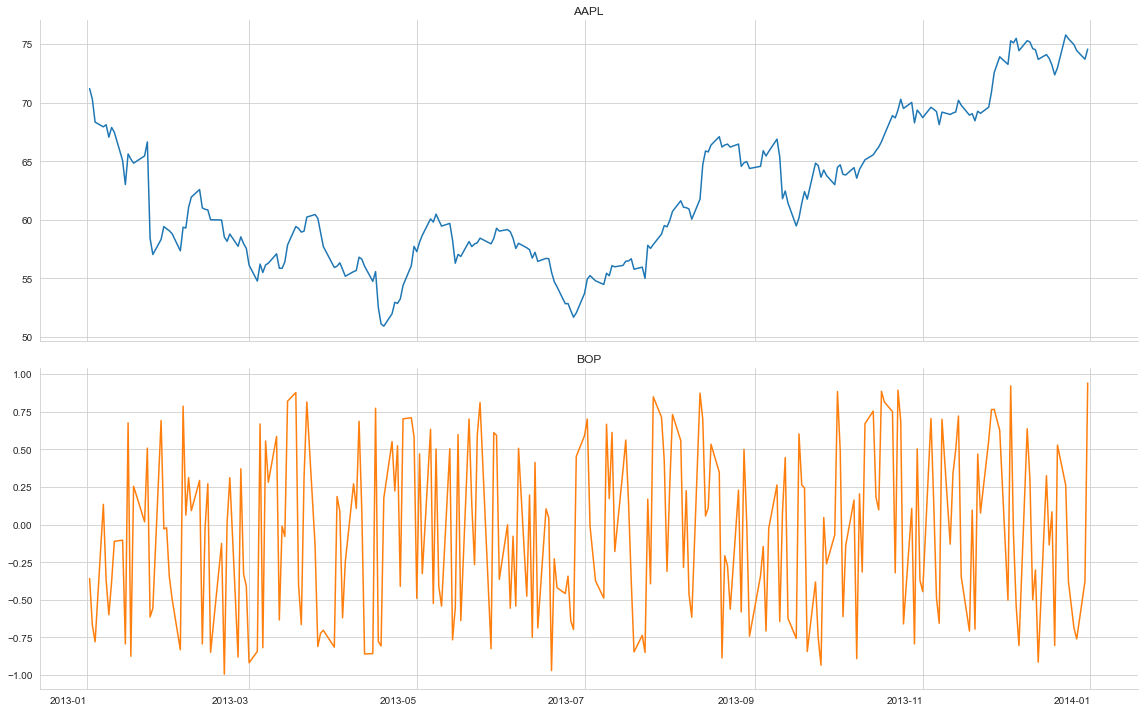

In [132]:
# 3-8. Balance Of Power (BOP)
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]
df['BOP'] = talib.BOP(open=df.open, high=df.high, low=df.low, close=df.close)
axes = df[['close', 'BOP']].plot(figsize=(16, 10), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

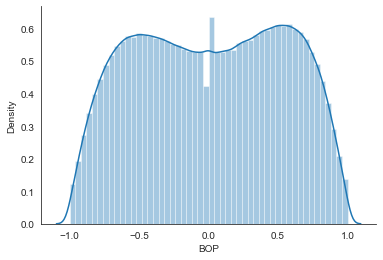

In [133]:
by_ticker = data.groupby('ticker', group_keys=False)
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x.open, x.high, x.low, x.close)))
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q), upper=data.BOP.quantile(1-q)))
    sns.despine()

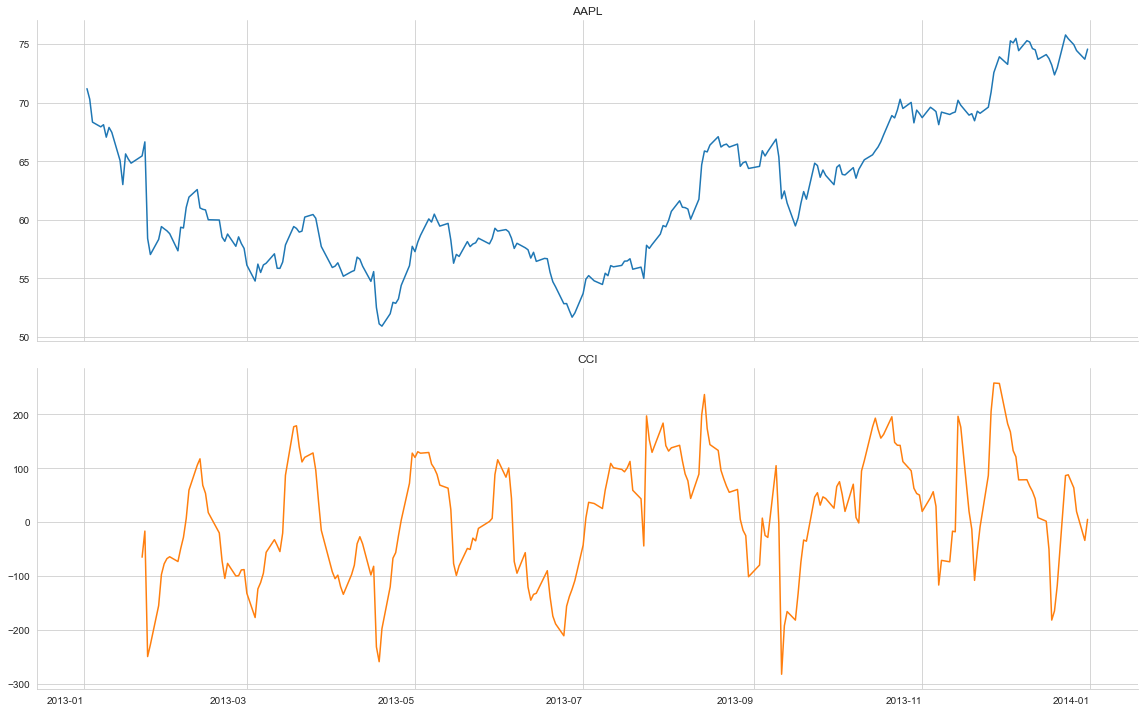

In [134]:
# 3-9. Commodity Channel Index (CCI)
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['CCI'] = talib.CCI(high=df.high, low=df.low, close=df.close, timeperiod=14)
axes = df[['close', 'CCI']].plot(figsize=(16, 10),  rot=0, subplots=True, title=['AAPL', 'CCI'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

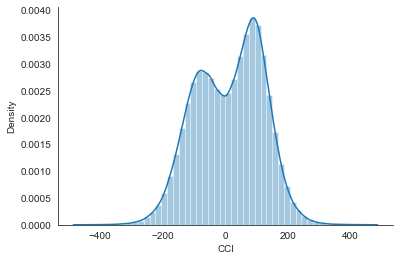

In [135]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high, x.low, x.close, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

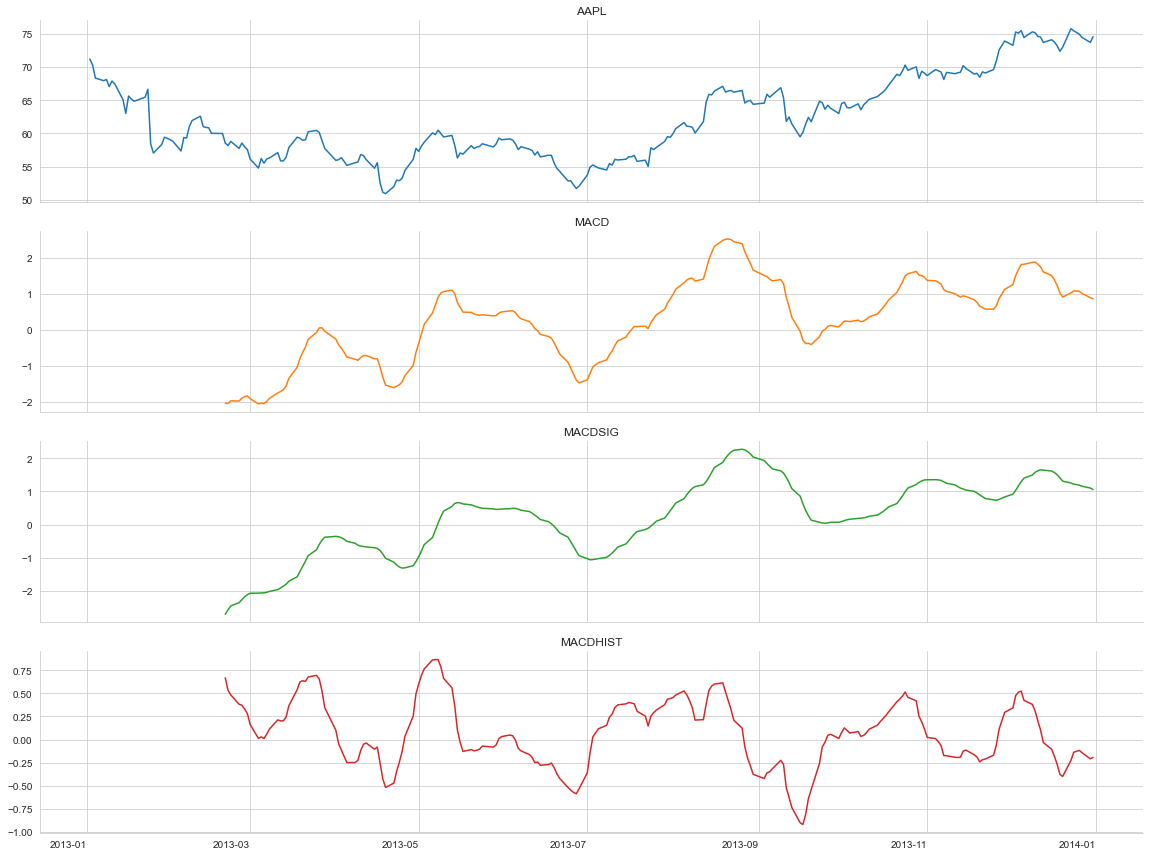

In [136]:
# 3-10. Moving Average Convergence/Divergence (MACD)
df = price_sample.loc['2013', ['close']]
macd, macdsignal, macdhist = talib.MACD(df.close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist
axes = df.plot(figsize=(16, 12), rot=0, subplots=True, title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [137]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd, 'MACD_SIGNAL': macdsignal, 'MACD_HIST': macdhist}, index=close.index)
data = (data.join(data.groupby(level='ticker').close.apply(compute_macd)))
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']
data[macd_indicators].corr()

MACD  MACD_SIGNAL  MACD_HIST
MACD         1.000000     0.955452   0.331106
MACD_SIGNAL  0.955452     1.000000   0.037857
MACD_HIST    0.331106     0.037857   1.000000

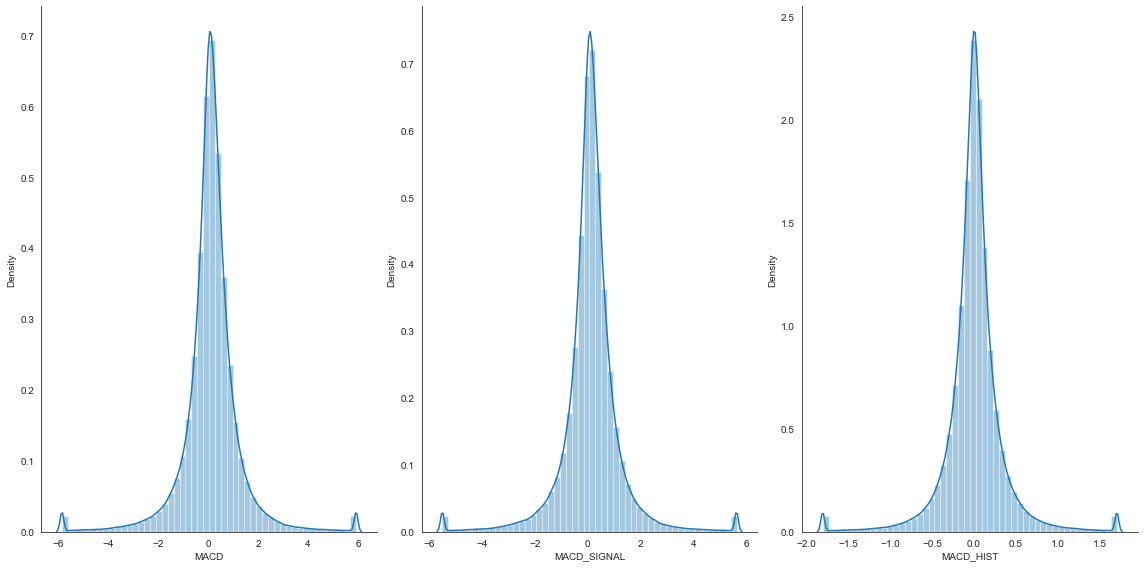

In [138]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(16, 8))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

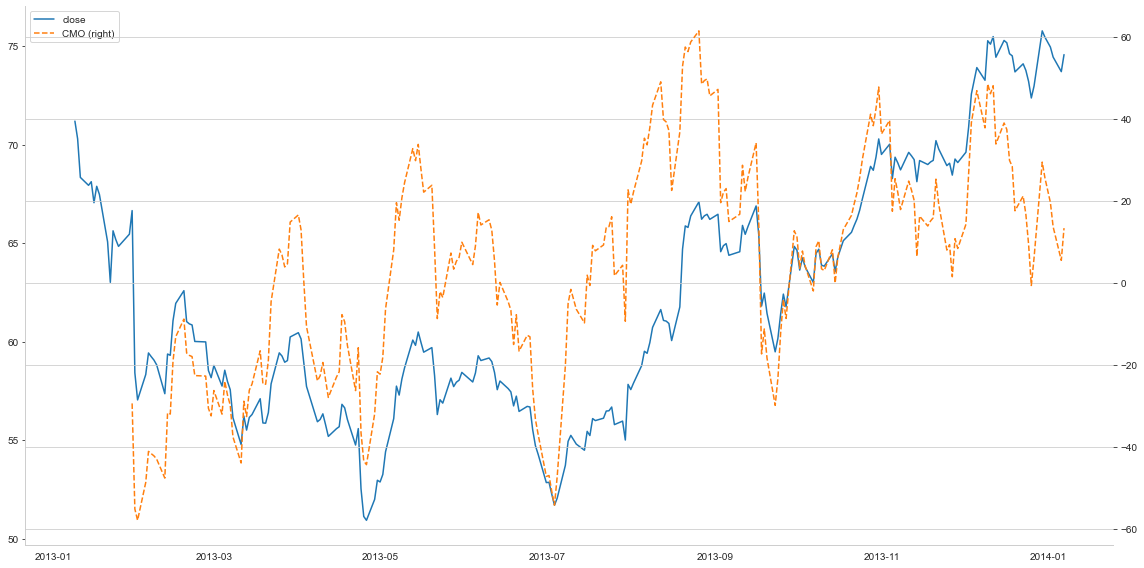

In [139]:
# 3-11. Chande Momentum Oscillator (CMO)
df = price_sample.loc['2013', ['close']]
df['CMO'] = talib.CMO(df.close, timeperiod=14)
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [140]:
# data['CMO'] = (by_ticker.apply(lambda x: talib.CMO(x.close, timeperiod=14)))
# sns.distplot(data.CMO);

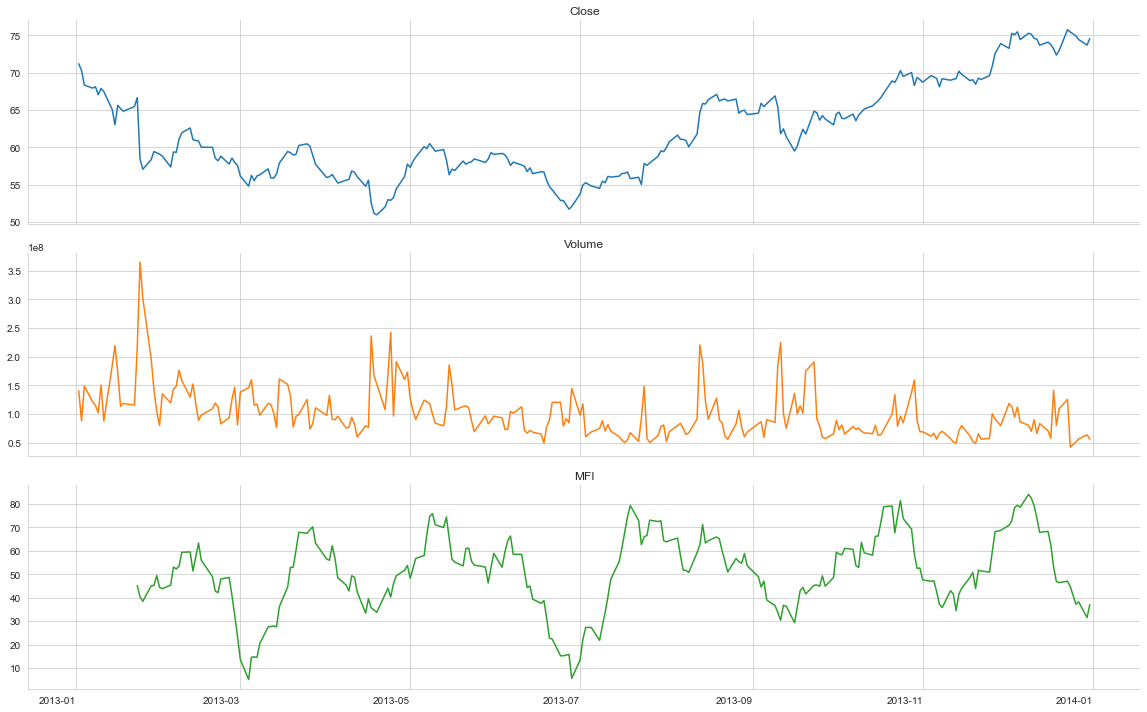

In [141]:
# 3-12. Money Flow Index
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['MFI'] = talib.MFI(df.high, df.low, df.close, df.volume, timeperiod=14)
axes = df[['close', 'volume', 'MFI']].plot(figsize=(16, 10), rot=0, subplots=True,
                                           title=['Close', 'Volume', 'MFI'], legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

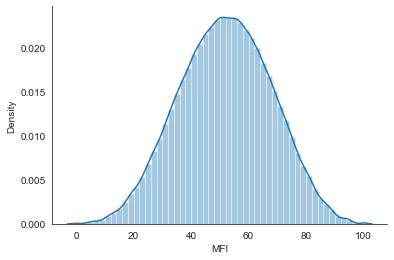

In [142]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high, x.low, x.close, x.volume, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

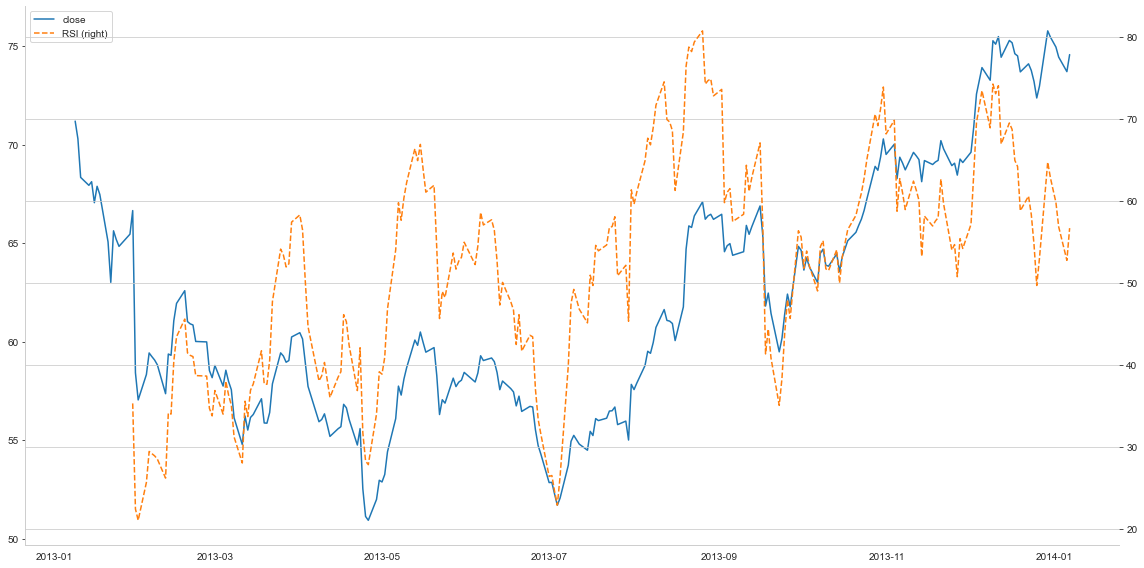

In [143]:
# 3-13. Relative Strength Index
df = price_sample.loc['2013', ['close']]
df['RSI'] = talib.RSI(df.close, timeperiod=14)
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

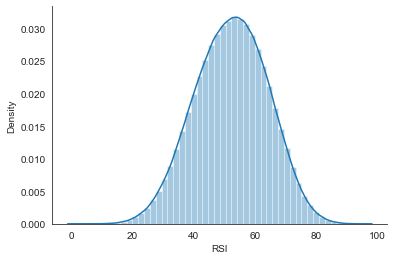

In [144]:
data['RSI'] = (by_ticker.apply(lambda x: talib.RSI(x.close, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

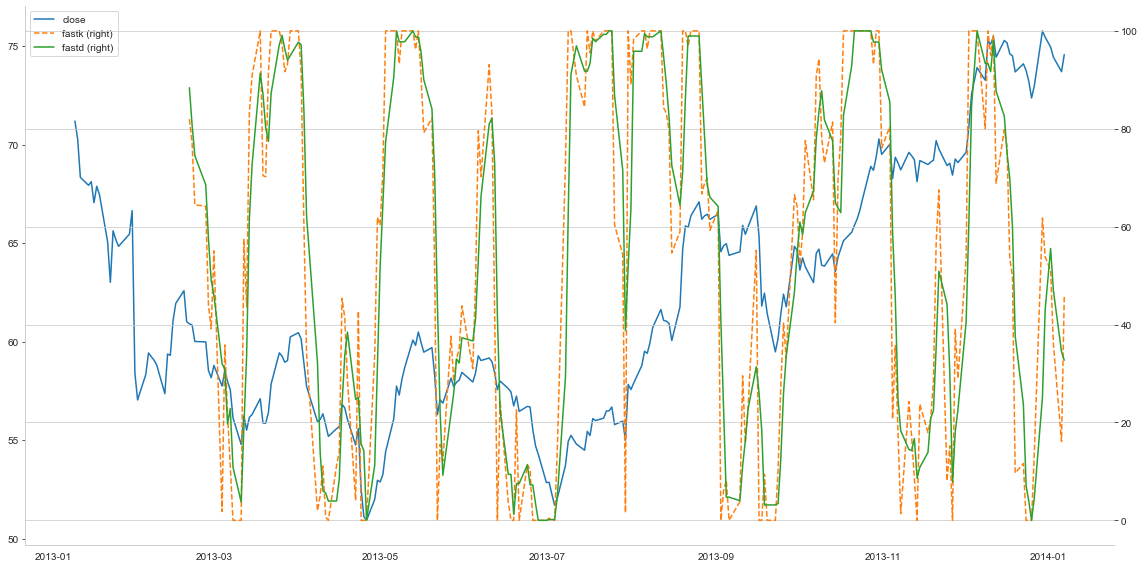

In [145]:
# 3-14. Stochastic RSI (STOCHRSI)
df = price_sample.loc['2013', ['close']]
fastk, fastd = talib.STOCHRSI(df.close, timeperiod=14, fastk_period=14, fastd_period=3, fastd_matype=0)
df['fastk'] = fastk
df['fastd'] = fastd
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [146]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close, timeperiod=14, fastk_period=14,
                                                             fastd_period=3, fastd_matype=0)[0]))
data.tail(5)

open       high        low      close     volume  \
ticker date                                                                
ZION   2016-12-22  43.341979  43.669875  42.934592  43.461214  1555955.0   
       2016-12-23  43.500959  43.659939  43.309189  43.580449  1243449.0   
       2016-12-27  43.818919  43.868601  43.391660  43.650003  1096332.0   
       2016-12-28  43.749366  43.749366  42.904783  43.004146  1055176.0   
       2016-12-29  42.994210  43.361851  42.358289  42.517269  1551615.0   

                      marketcap  sector    ret_01    ret_02    ret_03  ...  \
ticker date                                                            ...   
ZION   2016-12-22  1.032000e+10     0.0  0.002291 -0.003872  0.024356  ...   
       2016-12-23  1.032000e+10     0.0  0.002743  0.005041 -0.001139  ...   
       2016-12-27  1.032000e+10     0.0  0.001596  0.004344  0.006645  ...   
       2016-12-28  1.032000e+10     0.0 -0.014796 -0.013224 -0.010517  ...   
       2016-12-29  1.032000e+10     0.0 -0.011322 -0.025950 -0.024396  ...   

                        PPO    AARONOSC       BOP         CCI      MACD  \
ticker date                                                               
ZION   2016-12-22  4.497311   85.714286  0.162162  104.836046  1.821960   
       2016-12-23  4.384979   71.428571  0.226629  111.975984  1.786418   
       2016-12-27  4.257744  100.000000 -0.354167  112.400709  1.743762   
       2016-12-28  3.987045   57.142857 -0.882353   52.625942  1.638949   
       2016-12-29  3.638111   57.142857 -0.475248   -9.411910  1.499314   

                   MACD_SIGNAL  MACD_HIST        MFI        RSI   STOCHRSI  
ticker date                                                                 
ZION   2016-12-22     1.923030  -0.101070  62.727841  71.377938  29.606069  
       2016-12-23     1.895708  -0.109290  61.182241  71.844474  32.291696  
       2016-12-27     1.865319  -0.121556  59.062367  72.129855  33.934500  
       2016-12-28     1.820045  -0.181096  54.498530  65.491699   0.000000  
       2016-12-29     1.755899  -0.256585  46.193086  60.938744   0.000000  

[5 rows x 36 columns]

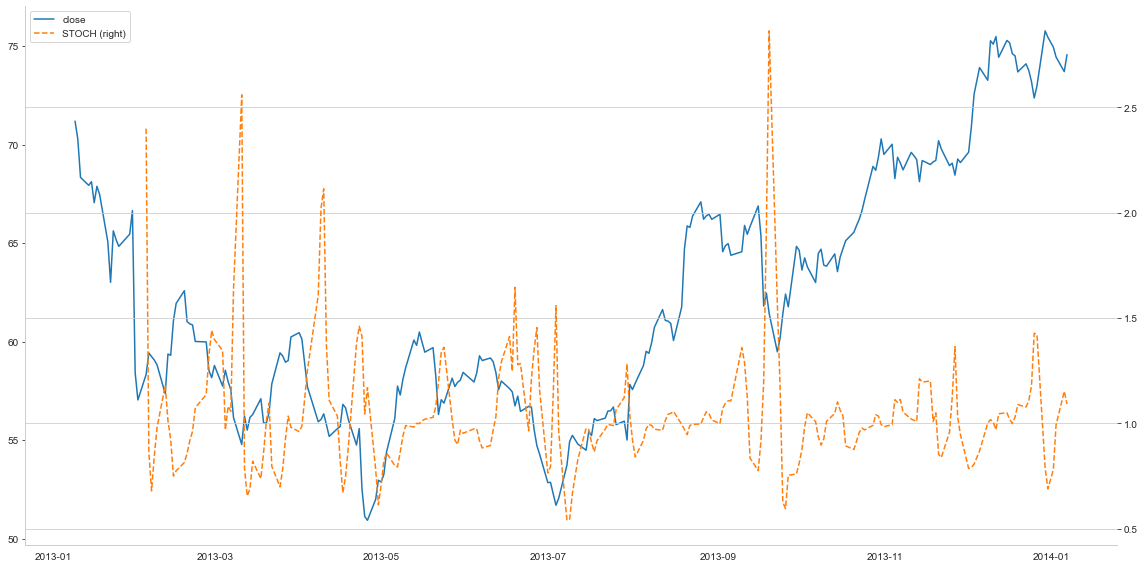

In [147]:
# 3-15. Stochastic (STOCH)
df = price_sample.loc['2013', ['high', 'low', 'close']]
slowk, slowd = talib.STOCH(df.high, df.low, df.close, fastk_period=14, slowk_period=3, slowk_matype=0,
                           slowd_period=3, slowd_matype=0)
df['STOCH'] = slowd / slowk
ax = df[['close', 'STOCH']].plot(figsize=(16, 8), rot=0, secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

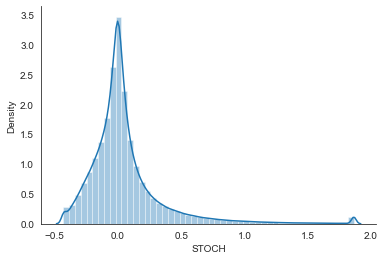

In [148]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close, fastk_period=fastk_period, slowk_period=slowk_period,
                           slowk_matype=slowk_matype, slowd_period=slowd_period, slowd_matype=slowd_matype)
    return slowd/slowk-1
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q), upper=data.STOCH.quantile(1-q)));

    sns.despine();

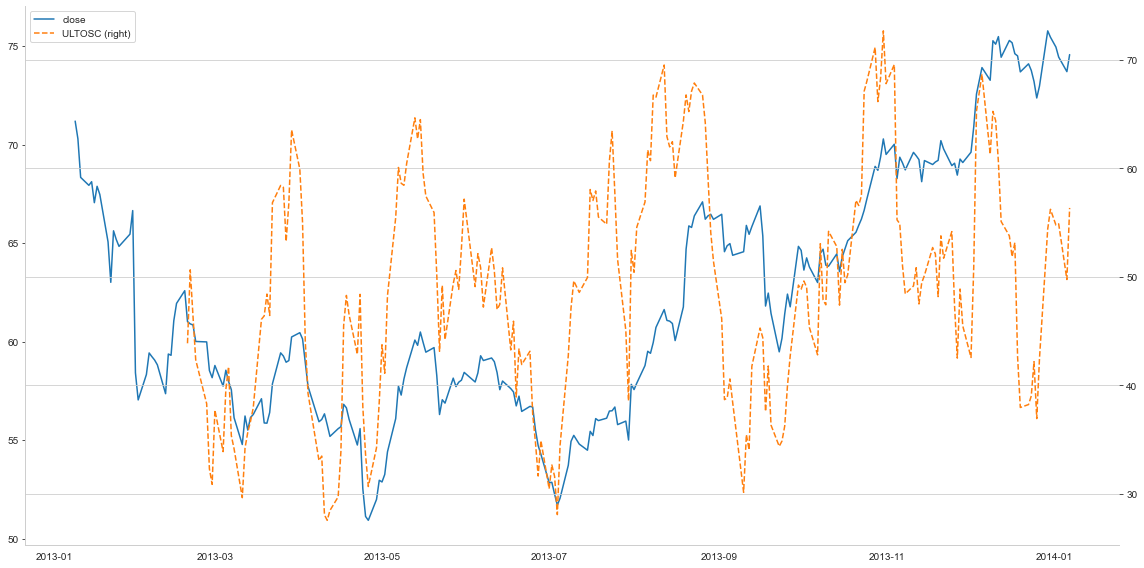

In [149]:
# 3-16. Ultimate Oscillator (ULTOSC)
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['ULTOSC'] = talib.ULTOSC(df.high, df.low, df.close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
ax = df[['close', 'ULTOSC']].plot(figsize=(16, 8), rot=0, secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

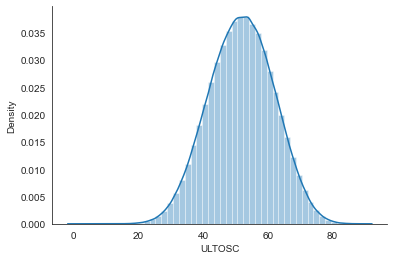

In [150]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high, x.low, x.close, timeperiod1=timeperiod1, timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)
data['ULTOSC'] = by_ticker.apply(compute_ultosc)
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

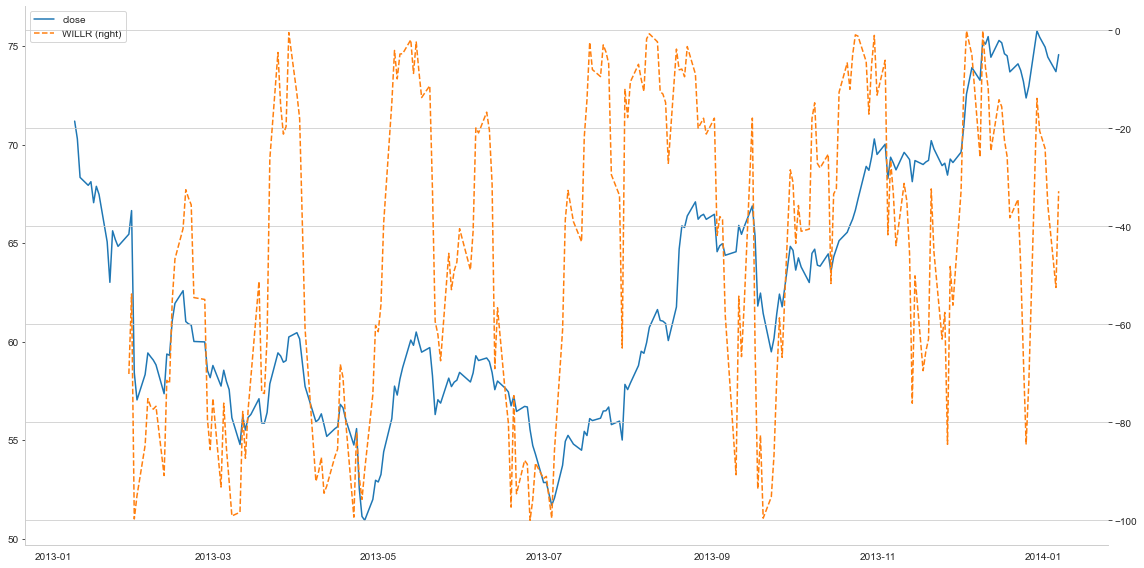

In [151]:
# 3-17. Williams' %R (WILLR)
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['WILLR'] = talib.WILLR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'WILLR']].plot(figsize=(16, 8), rot=0, secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

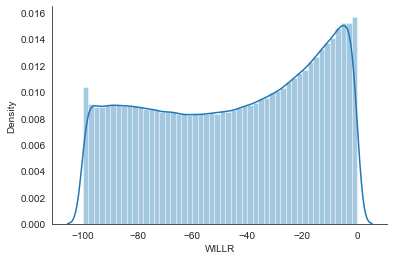

In [152]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

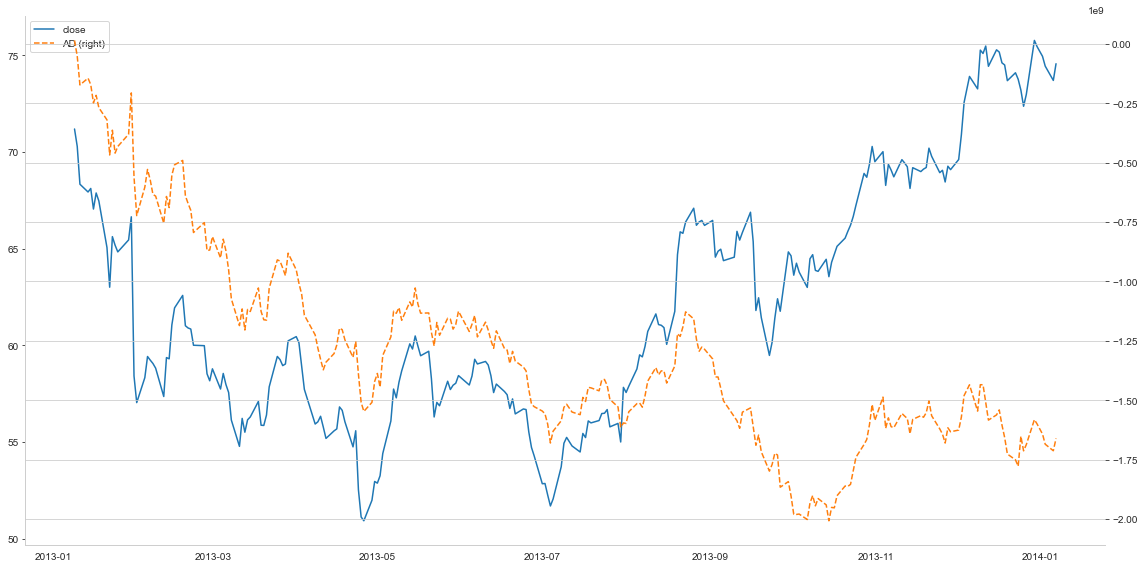

In [153]:
# 4. Volume Indicators: AD(Chaikin A/D Line), ADOSC(Chaikin A/D Oscillator), OBV(On Balance Volume)

# 4-1. Chaikin A/D Line
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['AD'] = talib.AD(df.high, df.low, df.close, df.volume)
ax = df[['close', 'AD']].plot(figsize=(16, 8), rot=0, secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [154]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    1.255093e+06
mean     3.820196e+01
std      4.457350e+01
min     -1.562873e+02
25%      5.206637e+00
50%      3.226342e+01
75%      6.711474e+01
max      2.413463e+02
Name: AD, dtype: float64

In [155]:
data.AD.sample(10)

ticker  date      
SCCO    2011-03-23    108.371708
ICE     2007-08-01    -11.319198
EXPE    2012-09-17     56.881308
DRI     2016-03-18     52.281966
SCHW    2008-05-14     -3.713033
KSS     2009-10-27     18.083850
JCI     2010-07-26     49.611384
DTV     2014-11-07     14.689544
CLR     2015-08-13     83.528311
MCK     2010-08-03     53.578832
Name: AD, dtype: float64

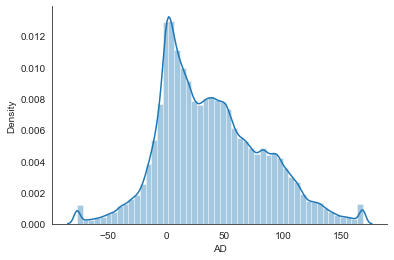

In [156]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q), upper=AD.quantile(1-q)));

    sns.despine();

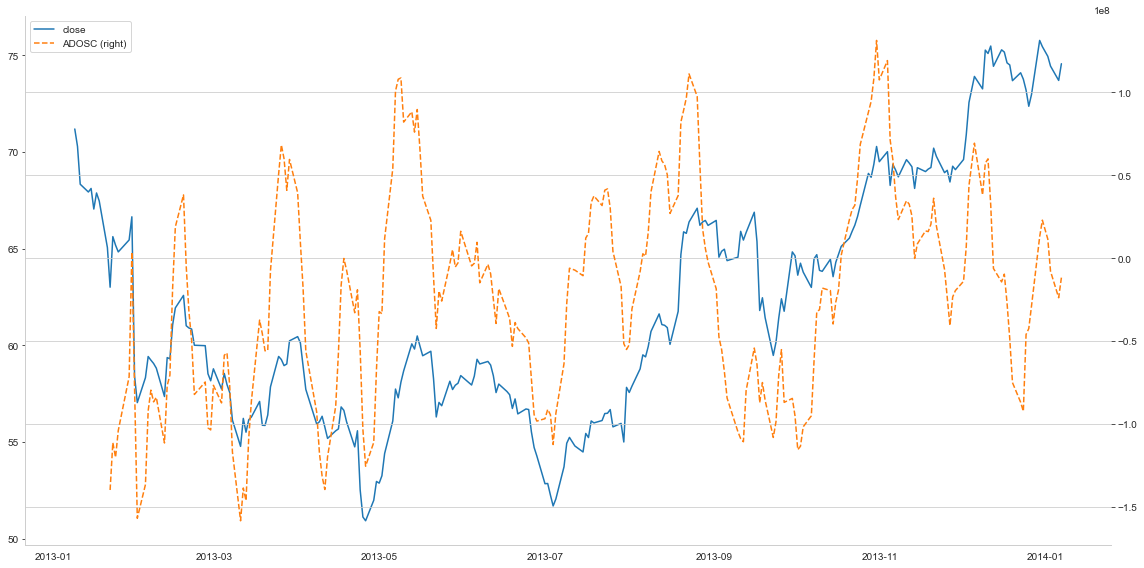

In [157]:
# 4-2. Chaikin A/D Oscillator (ADOSC)
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['ADOSC'] = talib.ADOSC(df.high, df.low, df.close, df.volume, fastperiod=3, slowperiod=10)
ax = df[['close', 'ADOSC']].plot(figsize=(16, 8), rot=0, secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

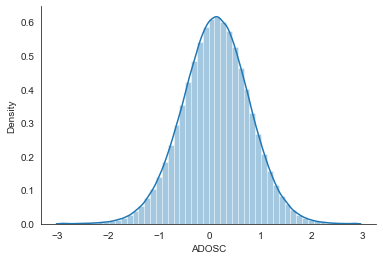

In [158]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high, x.low, x.close, x.volume, fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q), upper=data.ADOSC.quantile(1-q)))
    sns.despine();

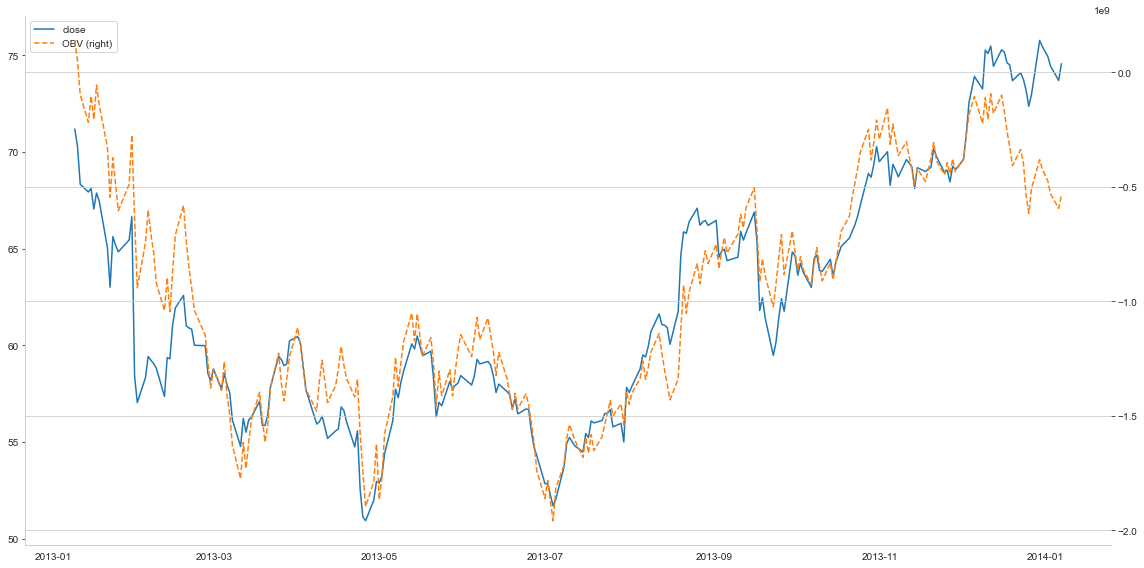

In [159]:
# 4-3. On Balance Volume (OBV)
df = price_sample.loc['2013', ['close', 'volume']]
df['OBV'] = talib.OBV(df.close, df.volume)
ax = df[['close', 'OBV']].plot(figsize=(16, 8), rot=0, secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

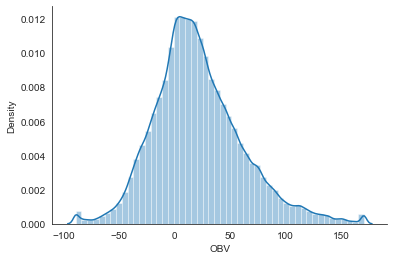

In [160]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close, x.volume)/x.expanding().volume.mean())
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q), upper=data.OBV.quantile(1-q)))
    sns.despine()

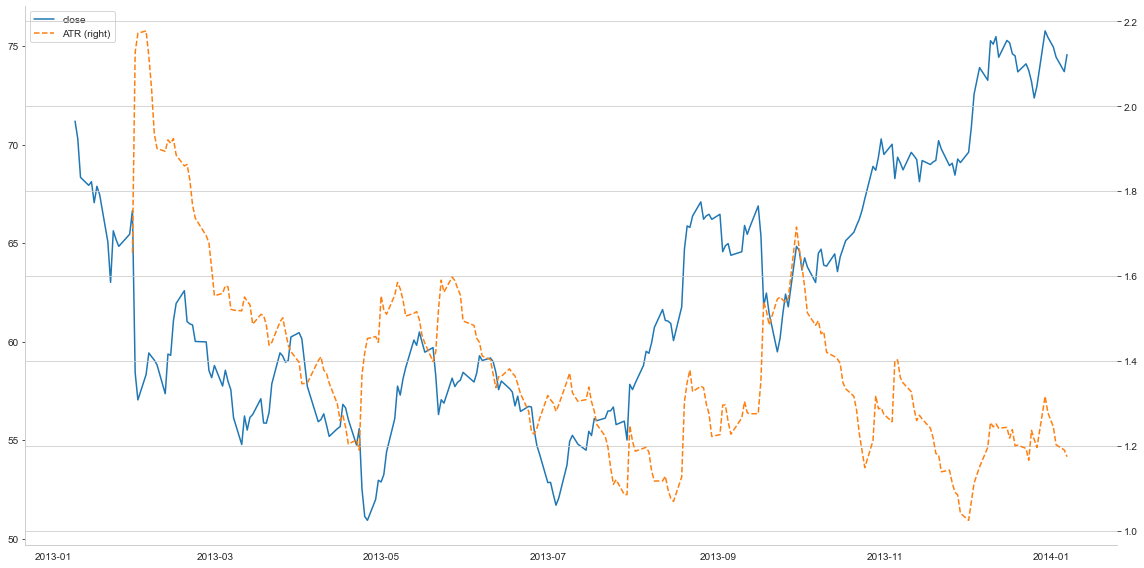

In [161]:
# 5. Volatility Indicators: TRANGE(True Range), ATR(Average True Range), NATR(Normalized Average True Range)

# 5-1. ATR
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['ATR'] = talib.ATR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ATR']].plot(figsize=(16, 8), rot=0, secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

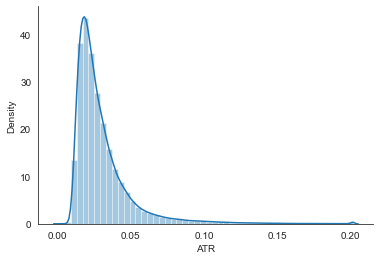

In [162]:
# Compute normalized version of ATR using rolling mean of price
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high, x.low, x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

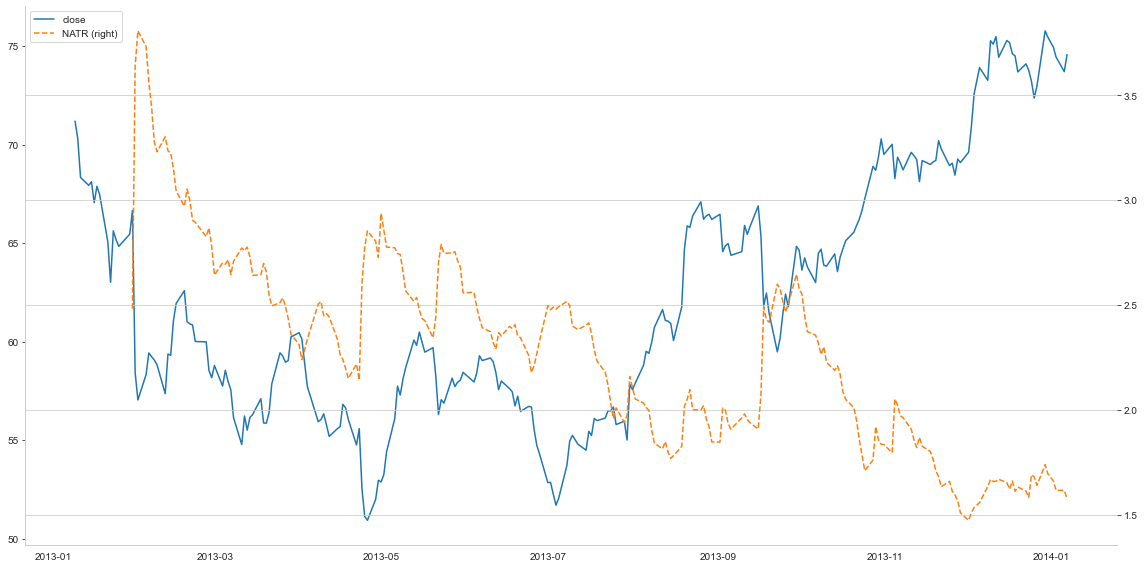

In [163]:
# 5-2. Normalized Average True Range (NATR)
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['NATR'] = talib.NATR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'NATR']].plot(figsize=(16, 8), rot=0, secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

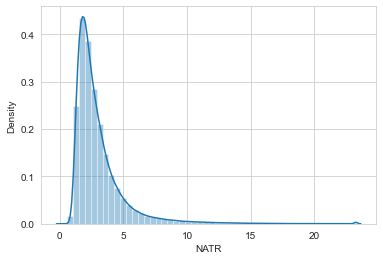

In [164]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high, x.low, x.close, timeperiod=14))
q = 0.001
sns.distplot(data.NATR.clip(upper=data.NATR.quantile(1-q)));

In [165]:
# Rolling Factor Betas
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench',
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
factors = factor_data.columns[:-1]
print(f'factors: {factors}')


t = 1
ret = f'ret_{t:02}'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret],
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

factors: Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')
21
63
252


In [166]:
# Size proxy
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))
data['size_proxy'] = data.marketcap.mul(data.size_factor).div(1e6)
# Persist results
data = (data.drop(['open', 'high', 'low', 'close', 'volume', 'marketcap'], axis=1)
        .replace((np.inf, -np.inf), np.nan))
data.dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 58 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   sector       1255093 non-null  float64
 1   ret_01       1254593 non-null  float64
 2   ret_02       1254093 non-null  float64
 3   ret_03       1253593 non-null  float64
 4   ret_04       1253093 non-null  float64
 5   ret_05       1252593 non-null  float64
 6   ret_10       1250093 non-null  float64
 7   ret_21       1244593 non-null  float64
 8   ret_42       1234093 non-null  float64
 9   ret_63       1223593 non-null  float64
 10  ret_126      1192093 non-null  float64
 11  ret_252      1129093 non-null  float64
 12  ret_fwd      1255093 non-null  float64
 13  BB_UP        1245593 non-null  float64
 14  BB_LOW       1245593 non-null  float64
 15  BB_SQUEEZE   1245593 non-null  float64
 16  HT           1223

In [167]:
with pd.HDFStore('data/data_alpha_factor.h5') as store:
    store.put('factors/common', data)